# Emoji Synthesis from Text using Conditional Generative Adversarial Networks 

This project focuses on designing and implementing a modified version of the conditional DCGAN that is used for Text to Emoji Synthesis. The modified architecture of the conditional Deep Convolutional Generative Adversarial Network uses a UNet as the generator of the GAN and uses the discriminator of the standard DCGAN itself.

## Importing important modules:

In [1]:
import os, os.path
from os import listdir
import glob
import PIL
import random
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt

## Data Preprocessing:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing the dataset from the device and convert the text describing the emojis to lower case and create 2 new columns that give us the length of the text and the number of words in the text.

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Folder/full_emoji 2 3 3.csv', encoding="ISO-8859-1")
df = df.set_index('image_id')
df['text3'] = df['text3'].str.lower()
df['text_length'] = df['text3'].apply(len)
df['word_count'] = df['text3'].apply(lambda x: len(x.split()))
data = df

This dataset consists of a total of 114 unique emojis that have been duplicated 7 times to create a dataset of 798 emojis. The column 'text' reflects the captions given for the emojis in www.unicode.org. However, these captions were not used and instead the captions mentioned in the column 'text3' as they help improve Text-Image Alignment.

In [4]:
data = data.reset_index() # This is done because originally image_id was the index
data['image_id']= pd.Series(range(1,df.shape[0]+1)) #starts with 1
data

image_id  unicode                     text                    text2  \
0           1  U+1F625    sad but relieved face     sad face with sweat    
1           2  U+1F910        zipper-mouth face        zipper-mouth face   
2           3  U+1F620               angry face      slightly angry face   
3           4  U+1F627           anguished face           anguished face   
4           5  U+1F630  anxious face with sweat  worried face with sweat   
..        ...      ...                      ...                      ...   
793       794      NaN              monkey face                      NaN   
794       795      NaN              monkey face                      NaN   
795       796      NaN              monkey face                      NaN   
796       797      NaN              monkey face                      NaN   
797       798      NaN              monkey face                      NaN   

                          text3  \
0               sad with sweat    
1    neutral with zipper mouth    
2                 yellow angry    
3                     anguished   
4       anxious face with sweat   
..                          ...   
793                      monkey   
794                      monkey   
795                      monkey   
796                      monkey   
797                      monkey   

                                           description  text_length  \
0    sad but relieved face. This face is yellow and...           15   
1    zipper-mouth face. A yellow face with a zipper...           26   
2    angry face. An angry looking yellow face. Has ...           13   
3    anguished face. This yellow face has raised ey...            9   
4    anxious face with sweat. A yellow face with a ...           23   
..                                                 ...          ...   
793                                                NaN            6   
794                                                NaN            6   
795                                                NaN            6   
796                                                NaN            6   
797                                                NaN            6   

     word_count  
0             3  
1             4  
2             2  
3             1  
4             4  
..          ...  
793           1  
794           1  
795           1  
796           1  
797           1  

[798 rows x 8 columns]

In [5]:
print("The maximum number of words is : " + str(data['word_count'].max()))

The maximum number of words is : 9


Creating a list that consists only of the captions:

In [6]:
text_list = []
for i in range(0,798,1):
    text_list.append(data['text3'].loc[i])
    
text_list[797]

'monkey'

Creating a list of the label numbers (image_id)

In [7]:
numbers = []
for i in range(0,798,1):
    numbers.append(int(data['image_id'].loc[i]))

    
numbers[797]

798

The next set of code reflects how to change the names of the files on the device in order to match them up with the .csv file.

In [8]:
# There is an issue with the file naming system which needs to be fixed:
#path = '/Users/taanya/Documents/Dissertation/Data/archive-2/image/Apple/'
#files = os.listdir(path)
#for i in range(300,400,1):
#    old = str(i)+'.png'
#    new = str(i-2)+'.png'
#    os.rename(os.path.join(path, old), os.path.join(path, new))

In [9]:
# Dimension of Word Embeddings (300x1)
embedding_dim = 300
# Latent Dimension (512x1)
latent_dim = 512
# Shape of the images are (64,64,4) as they have a 4th channel that reflects transparency (alpha)
image_shape = (64,64,4)

Now we use PIL to access all the images and ensure that all of them are resized to 64x64, after which we load them into an array. The commented part of the code below can be used if we want to convert the images from (64x64x4) to (64x64x3) and convert it to RGB format.

In [10]:
from tensorflow.keras.preprocessing.image import img_to_array
import cv2
path = '/content/drive/MyDrive/Folder/New/'
def loadImages(path):
    files = os.listdir(path)
    loadedImages = []
    for i in range(1,799,1):
        name = str(i)+'.png'
        img = Image.open(path + name)
        img = img.convert('RGBA')
        #Resizing the images to 64x64 and storing in an array
        new_width  = 64
        new_height = 64
        imgresized = img.resize((new_width, new_height), Image.ANTIALIAS)
        #imgresized = np.asarray(imgresized).astype(np.float32)
        #imgresized = imgresized.convert('RGBA') #For transparency we need to use RGBA but it makes it 64x64x4
        # Therefore, we need to set the alpha value and make those pixels with transparency values less than 128 as white.
        #imgresized = img_to_array(imgresized)
        #imgresized[imgresized[...,-1]<=128] = [255,255,255,0]
        #print(imgresized)
        #imgresized = Image.fromarray(imgresized.astype(np.uint8))
        #imgresized = imgresized.convert('RGB')
        loadedImages.append(imgresized)
        #print(len(loadedImages))    
    return loadedImages
# Saving all the Images in an array image_lists
image_lists = loadImages(path)

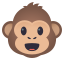

In [11]:
image_lists[797]

Converting the images to an array and normalising them to values between -1 and 1 and saving them in a list named image_listss

In [12]:
image_listss = []
for i in range(0,798,1):
    image_lists[i] = img_to_array(image_lists[i])
    image_lists[i] = (image_lists[i].astype(np.float32)/127.5) - 1.0
    image_listss.append(image_lists[i])

It is important to save the images in an array directly instead of converting a list that contains the images to an array as that changes the colours of the image.

In [13]:
# Creating an empty array called image_list and putting all the images into it.
image_list = np.empty((798, 64, 64, 4))
for i in range(0,798,1):
  image_list[i] = image_listss[i]

image_list = np.array(image_list)

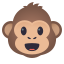

In [14]:
# Converting the array back to an image:
im = image_list[797] * 127.5 + 127.5
Image.fromarray(im.astype(np.uint8)).convert('RGBA')

Now that the data is prepared, we can move on to the tokenizing the texts to use for the embedding portion of the project:

### Tokenization:

The block of code below removes quotation marks and any punctuation marks fromthe text.

In [15]:
import re
caption_list = []

for text in text_list:
        text = text.replace("”", "")
    # Removing Punctuation marks:
        regex_any_symbol = re.compile("[!-/:-@[-`{-~]")
        filtered_sentence = re.sub(regex_any_symbol, "", text)
        caption_list.append(filtered_sentence)

In [16]:
len(caption_list)

798

Converting the list consisting of captions and the list consisting of image ids to an array. Images were already saved in an array format in 'image_list'

In [17]:
# Converting the lists to arrays:
caption_list = np.array(caption_list, dtype=object)
numbers = np.array(numbers, dtype=int)

In [18]:
print("The size of the total Dataset is: %s"  %len(image_list))

The size of the total Dataset is: 798


Splitting the 3 arrays into training and test sets:

In [19]:
from sklearn.model_selection import train_test_split
image_train,image_test,caption_train,caption_test,numbers_train,numbers_test = train_test_split(image_list, caption_list, numbers, test_size = 0.033)

In [20]:
print("The size of the training set is: %s"  %len(image_train))
print("The size of the test set is: %s"  %len(image_test))

The size of the training set is: 771
The size of the test set is: 27


In [21]:
caption_list[0]

'sad with sweat '

## Embedding

There are 3 types of word embeddings implemented : <br>
1. Glove <br>
2. Word2Vec <br>
3. FastText

----> GLOVE MODEL

In [22]:
import urllib.request
import zipfile
def load_glove(glove_file_path, embedding_dim = 300):
    print("Loading glove file, please wait...")
    _word2em = {}
    file = open(glove_file_path, mode="rt", encoding="utf8")
    for line in file:
        words = line.strip().split()
        word = words[0]
        embeds = np.array(words[1:], dtype=np.float32)
        _word2em[word] = embeds
    file.close()
    print("Finished.")
    return _word2em

In [23]:
word2em = load_glove("/content/drive/MyDrive/Folder/glove.6B.300d.txt")

Loading glove file, please wait...
Finished.


----> WORD2VEC IMPLEMENTATION <br>
Word2Vec model was implemented using the Gensim library. The pretrained model was trained on the 'word2vec-google-news-300'

In [24]:
#import gensim.downloader
#print(list(gensim.downloader.info()['models'].keys()))

In [25]:
# Download the "word2vec-google-news-300" embeddings
#print("Loading word2vec file...")
#word2em = gensim.downloader.load('word2vec-google-news-300')
#print("Finished.")

----> FAST-TEXT IMPLEMENTATION <br>
FastText model was implemented using the Gensim library.

In [26]:
#from gensim.models import KeyedVectors
#word2em = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Folder/fasttext-wiki.vec')

In [27]:
word2em["grinning"]

array([-0.22034  ,  0.069209 ,  0.51843  , -0.3711   , -0.33084  ,
        0.39212  , -0.10829  , -0.61088  , -0.092814 ,  0.68441  ,
       -0.33549  ,  0.2144   ,  0.032495 ,  0.032207 , -0.024584 ,
        0.24154  , -0.2797   , -0.19665  , -0.039011 ,  0.035342 ,
        0.30273  ,  0.16175  ,  0.55135  , -0.15673  , -0.39614  ,
       -0.3798   ,  0.037229 , -0.36045  ,  0.425    ,  0.52472  ,
       -0.72152  , -0.77287  , -0.10571  ,  0.032737 ,  0.029022 ,
        0.26788  , -0.33599  , -0.29514  , -0.20694  ,  0.50218  ,
       -0.070346 , -0.37908  , -0.32694  ,  0.21422  , -0.26674  ,
       -0.075791 ,  0.27719  , -0.3463   ,  0.37417  , -0.44677  ,
       -0.2506   , -0.25979  ,  0.26726  ,  0.27022  ,  0.27337  ,
       -0.12956  ,  0.12136  ,  0.18023  ,  0.18736  ,  0.20806  ,
        0.20543  , -0.10671  ,  0.23681  ,  0.31253  ,  0.015709 ,
       -0.22769  , -0.48802  , -0.76826  ,  0.54529  , -0.19531  ,
       -0.29325  ,  0.16697  , -0.20429  , -0.060363 ,  0.2936

Vectorizing the sentences: <br>
For this we split the sentence into its words and use the embedding size of 300 and find the vectors of each of the words in the sentence and then add them up to find the vector of the whole sentence. We also use the NLTK library to remove stopwords.

In [28]:
# returns embedding<output> for a sentence<input>
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
def vectorize_sentence(sentence, embedding_dim=300):
    words = sentence.strip().split(" ")
    em = np.zeros(shape=(embedding_dim,))
    for word in words:
        if word not in stop_words:
            try:
            #print(word)
                em = np.add(em, word2em[word])
                #print(word,em)
            except KeyError:
            #             print('Error: Not found "' + word + '"')
                pass
        else:
            #print(word)
            pass 
    return em

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [29]:
# vectorize list of sentences
def vectorize_sent_list(sent_list):
    out = []
    for sent in sent_list:
        v = vectorize_sentence(sent)
        out.append(v)
    return np.asarray(out).astype(np.float32)

In [30]:
#print(caption_list)
vectorize_sent_list(caption_list)
#vectorize_sent_list(caption_list).shape

array([[ 0.25834998,  0.17021999,  0.10791996, ...,  0.16979599,
        -0.07462001,  1.01283   ],
       [-0.50914   ,  0.1266    , -0.555413  , ...,  0.813503  ,
         0.1596212 ,  0.442541  ],
       [ 0.013896  , -0.145911  ,  0.64828   , ...,  0.11712399,
         0.74569   , -1.07201   ],
       ...,
       [-0.084522  ,  0.18224   , -0.17287   , ...,  0.41062   ,
         0.46047   ,  0.11676   ],
       [-0.084522  ,  0.18224   , -0.17287   , ...,  0.41062   ,
         0.46047   ,  0.11676   ],
       [-0.084522  ,  0.18224   , -0.17287   , ...,  0.41062   ,
         0.46047   ,  0.11676   ]], dtype=float32)

## Model

In [31]:
# Importing all the necessary libraries 
from __future__ import print_function, division
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, concatenate, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Concatenate
from tensorflow.keras import backend as kb
from tensorflow.keras.layers import Lambda

#### Building Generator:

For this project we will be using a conditional GAN in order to convert texts into images. The Keras library has been used to build the GAN.  This GAN uses a UNet architecture for the generator. The generator takes noise as input (latent dimension: 512) and creates images.

In [32]:
def build_generator(latent_dim = 512, embedding_dim = 300, channels = image_shape[2]): 
  generator_input = Input(shape=(latent_dim,), name="g_input") 
  cond_input = Input(shape=(embedding_dim,), name="cond_g_input") 
  cond_output = Dense(512)(cond_input)
  x = concatenate([generator_input, cond_output])
  x = Dense(64 * 64 * 4)(x)
  x = Reshape((64, 64, 4))(x)


  output_ch = 4
  filters=64
  # ENCODER
  x = Conv2D(filters*1, kernel_size=(3,3), strides=(2, 2), padding="same")(x); e1 = x
  x = BatchNormalization()( Conv2D(filters*2, kernel_size=(3,3), strides=(2, 2), padding="same")( LeakyReLU(0.02)(x) ) ); e2 = x
  x = BatchNormalization()( Conv2D(filters*4, kernel_size=(3,3), strides=(2, 2), padding="same")( LeakyReLU(0.02)(x) ) ); e3 = x
  #x = BatchNormalization()( Conv2D(filters*4, kernel_size=(3, 3), strides=(1, 1), padding="same")( LeakyReLU(0.02)(x) ) ); e4 = x
  x = BatchNormalization()( Conv2D(filters*8, kernel_size=(3,3), strides=(2, 2), padding="same")( LeakyReLU(0.02)(x) ) ); e4 = x
  x = BatchNormalization()( Conv2D(filters*8, kernel_size=(3,3), strides=(2, 2), padding="same")( LeakyReLU(0.02)(x) ) ); e5 = x
  # BOTTLENECK
  x = BatchNormalization()( Conv2D(filters*8, kernel_size=(3,3), strides=(2, 2), padding="same")( LeakyReLU(0.02)(x) ) ); e6 = x
  x = Conv2D(filters*8, kernel_size=(3,3), strides=(2, 2), padding="same")( LeakyReLU(0.02)(x) )  ; e7 = x
  # DECODER
  x = BatchNormalization()( Conv2DTranspose(filters*8, kernel_size=(3,3), strides=(2, 2), padding="same")( Activation("relu")(x) ) ); x = Concatenate()([Dropout(0.5)(x), e5])
  x = BatchNormalization()( Conv2DTranspose(filters*8, kernel_size=(3,3), strides=(2, 2), padding="same")( Activation("relu")(x) ) ); x = Concatenate()([Dropout(0.5)(x), e4])
  x = BatchNormalization()( Conv2DTranspose(filters*4, kernel_size=(3,3), strides=(2, 2), padding="same")( Activation("relu")(x) ) ); x = Concatenate()([Dropout(0.5)(x), e3])
  #x = BatchNormalization()( Conv2DTranspose(filters*4, kernel_size=(3, 3), strides=(1, 1), padding="same")( Activation("relu")(x) ) ); x = Concatenate()([Dropout(0.5)(x), e3])
  x = BatchNormalization()( Conv2DTranspose(filters*2, kernel_size=(3,3), strides=(2, 2), padding="same")( Activation("relu")(x) ) ); x = Concatenate()([Dropout(0.5)(x), e2])
  x = BatchNormalization()( Conv2DTranspose(filters*1, kernel_size=(3,3), strides=(2, 2), padding="same")( Activation("relu")(x) ) ); x = Concatenate()([Dropout(0.5)(x), e1])
  x = Conv2DTranspose(output_ch, kernel_size=(3,3), strides=(2, 2), padding="same")( Activation("relu")(x) )

  x = Activation("tanh")(x)
  generator = Model([generator_input, cond_input], x)
  generator.summary()

  return generator

#### Building Discriminator:

In [33]:
from tensorflow.keras import layers
def build_discriminator(embedding_dim=300, img_shape= image_shape):
    discriminator_input = Input(shape=img_shape, name="d_input")
    discriminator_input = layers.GaussianNoise(0.2)(discriminator_input)
    cond_input = Input(shape=(embedding_dim,), name="cond_d_input")

    D = Conv2D(128, kernel_size=3, strides=2, padding="same")(discriminator_input)
    D = LeakyReLU(0.02)(D)
    
    D = Conv2D(256, kernel_size=3, strides=2, padding="same")(D)
    D = ZeroPadding2D(padding=((0, 1), (0, 1)))(D)
    D = LeakyReLU(0.02)(D)
    D = Dropout(0.25)(D)

    cond_d_hidden = Dense(512)(cond_input)
    cond_d_hidden = Reshape((1, 1, 512))(cond_d_hidden)


    cond_d_output = Lambda(
        lambda x: kb.tile(x, [1, 17, 17, 1]), output_shape=[17, 17, 512]
    )(cond_d_hidden)

    D = concatenate([D, cond_d_output], axis=-1)
    D = Conv2D(1024, kernel_size=3, strides=1, padding="same")(D)
    D = LeakyReLU(0.02)(D)

    D = Flatten()(D)
    discriminator_output = Dense(1, activation="sigmoid")(D)

    discriminator = Model([discriminator_input, cond_input], discriminator_output)
    discriminator.summary()

    return discriminator

Now we are building the Generator.

In [34]:
generator = build_generator()
z = Input(shape=(latent_dim,))
cond_input = Input(shape=(embedding_dim,))
img = generator([z, cond_input])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cond_g_input (InputLayer)      [(None, 300)]        0           []                               
                                                                                                  
 g_input (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 512)          154112      ['cond_g_input[0][0]']           
                                                                                                  
 concatenate (Concatenate)      (None, 1024)         0           ['g_input[0][0]',                
                                                                  'dense[0][0]']              

#### Optimizers <br>
For the discriminator we have used the Adam optimizer and the block of code below builds and compiles the discriminator. When we combine the generator with the discriminator we do not train the discriminator. Hence, we set discriminator.trainable to False.

In [35]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, SGD
#optimizer_d = tf.keras.optimizers.RMSprop(learning_rate = 0.0001 , decay = 0.00001 , clipvalue=1.0)  #0.000005
optimizer_d = Adam(learning_rate = 0.0001, beta_1 = 0.5)
#optimizer_d = tf.keras.optimizers.SGD(learning_rate=0.001)

# Build and Compile Discriminator
discriminator = build_discriminator()
discriminator.compile(
    loss="binary_crossentropy", optimizer=optimizer_d, metrics=["accuracy"]
)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator([img, cond_input])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 4)]  0           []                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 32, 32, 128)  4736        ['input_3[0][0]']                
                                                                                                  
 leaky_re_lu_6 (LeakyReLU)      (None, 32, 32, 128)  0           ['conv2d_7[1][0]']               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 16, 16, 256)  295168      ['leaky_re_lu_6[1][0]']          
                                                                                            

Combining the Generator and Discriminator and compiling them and using the Adam optimizer.

In [36]:
combined = Model([z, cond_input], valid)
#optimizer_g_1 = tf.keras.optimizers.RMSprop(learning_rate=0.0004, decay=0.00001, clipvalue=1.0)
#optimizer_g_1 = tf.keras.optimizers.SGD(learning_rate=0.009)
optimizer_g_1 = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
#Adam(learning_rate = 0.0002, beta_1 = 0.5)
combined.compile(loss="binary_crossentropy", optimizer= optimizer_g_1, metrics = ["accuracy"])
combined.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 model (Functional)             (None, 64, 64, 4)    35772804    ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 model_1 (Functional)           (None, 1)            7828865     ['model[0][0]',            

## Training the model

In [37]:
# Epochs and Batch Size
EPOCHS = 1001
BATCH_SIZE = 27 
gen_loss, dis_loss, gen_acc, dis_acc= list(), list(), list(), list()

In [38]:
import time
import pandas as pd
from numpy.random import random
from numpy.random import choice

# randomly flip some labels
def noisy_labels(y, p_flip):
	# determine the number of labels to flip
	n_select = int(p_flip * y.shape[0])
	# choose labels to flip
	flip_ix = choice([i for i in range(y.shape[0])], size=n_select)
	# invert the labels in place
	y[flip_ix] = 1 - y[flip_ix]
	return y

def train(epochs=EPOCHS, batch_size=BATCH_SIZE, save_interval = 20, latent_dim = 512):
        
        
    # load dataset
    (X_train, Captions, X_test, Captions_test, Labels) = (
        image_train,
        caption_train,
        image_test,
        caption_test,
        numbers_train,
    )

    caption_list_train = []
    caption_list_test = []
    
    for caption in Captions:
        caption_list_train.append([str(caption)])
    for caption in Captions_test:
        caption_list_test.append([str(caption)])
        
    df = pd.DataFrame(caption_list_train, columns=["caption"])
    df.to_csv("/content/drive/MyDrive/Folder/caption_train.csv")
    df = pd.DataFrame(caption_list_test, columns=["caption"])
    df.to_csv("/content/drive/MyDrive/Folder/caption_test.csv")

    # Adversarial ground truths
    #noise_prop = 0.03
    valid = np.ones((batch_size, 1))
    #flipped_idx = np.random.choice(np.arange(len(valid)), size=int(noise_prop*len(valid)))
    #valid[flipped_idx] = 1 - valid[flipped_idx]
    #valid += 0.05 * tf.random.uniform(valid.shape)
    #valid = noisy_labels(valid, 0.05)
    #valid = np.random.uniform(low=0.9, high=1.0, size=(batch_size,1))
    #valid = np.ones((batch_size,1))*-1
    #print(valid)
    fake = np.zeros((batch_size, 1))
    #flipped_idx = np.random.choice(np.arange(len(fake)), size=int(noise_prop*len(fake)))
    #fake[flipped_idx] = 1 - fake[flipped_idx]
    #fake += 0.05 * tf.random.uniform(fake.shape)
    #fake = noisy_labels(fake, 0.05)
    #fake = np.random.uniform(low = 0.0, high = 0.1, size=(batch_size,1))
    #fake = np.ones((batch_size,1)
    
    
    batch_count = int(X_train.shape[0] / batch_size)
    history = []
    history_test = []
    for epoch in range(epochs):
        
        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        #if epoch <= 20:
            #combined.compile(loss="binary_crossentropy", optimizer=optimizer_g_1, metrics = ["accuracy"])
            #print("gen : 0.00005, dis : 0.000005")
        #else:
            #combined.compile(loss="binary_crossentropy", optimizer=optimizer_g_2, metrics = ["accuracy"])
            #print ("gen : 0.000005, dis : 0.0000005")

        for batch_index in range(batch_count):

            # Training the Discriminator
            imgs = X_train[batch_index * batch_size : (batch_index + 1) * batch_size]
            texts_input = Captions[
                batch_index * batch_size : (batch_index + 1) * batch_size
            ]
            
            texts = vectorize_sent_list(texts_input)
            
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            gen_imgs = generator.predict([noise, texts])
            # Train the discriminator (real classified as ones and generated as zeros)
            start = time.time()
            d_loss_real = discriminator.train_on_batch([imgs, texts], valid)
            d_loss_fake = discriminator.train_on_batch([gen_imgs, texts], fake)
            batch_time_d = time.time() - start
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            dis_loss.append(d_loss[0])
            dis_acc.append(d_loss[1])


            # Training the Generator

            start = time.time()
            g_loss = combined.train_on_batch([noise, texts], valid)
            gen_loss.append(g_loss[0])
            gen_acc.append(g_loss[1])
            batch_time_g = time.time() - start

            # Plot the progress
            batch_time = batch_time_d + batch_time_g
            print(
                "%d-%d [D loss: %f] [G loss: %f] [Time: %f]"
                % (epoch, batch_index, d_loss[0], g_loss[0], batch_time)
            )
            history.append(
                [epoch, batch_index, d_loss[0], 100*d_loss[1], g_loss[0], 100*g_loss[1],batch_time]
            )

        # Test the model
        texts_test = vectorize_sent_list(Captions_test)
        noise_test = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs_test = generator.predict([noise_test, texts_test])
        start = time.time()
        d_loss_real_test = discriminator.test_on_batch([X_test, texts_test], valid)
        d_loss_fake_test = discriminator.test_on_batch([gen_imgs_test, texts_test], fake)
        batch_time_d_test = time.time() - start
        d_loss_test = 0.5 * np.add(d_loss_real_test, d_loss_fake_test)
        start = time.time()
        g_loss_test = combined.test_on_batch([noise_test, texts_test], valid)
        batch_time_g_test = time.time() - start

        # Plot the test progress
        batch_time_test = batch_time_d_test + batch_time_g_test
        print(
            "%d (test) [D loss: %f] [G loss: %f] [Time: %f]"
            % (
                epoch,
                d_loss_test[0],
                g_loss_test[0],
                batch_time_test,
            )
        )
        history_test.append(
            [epoch, d_loss_test[0], 100 * d_loss_test[1], g_loss_test[0], 100*g_loss_test[1], batch_time_test]
        )
        

        # If at save interval => save generated image samples & training weights
        if epoch % save_interval == 0:
            plot_history_loss(dis_loss, gen_loss)
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            texts_input = Captions[idx]
            texts = vectorize_sent_list(texts_input)
            save_imgs(epoch, texts)

            generator.save_weights(
                filepath="/content/drive/MyDrive/Folder/Generator-weights/generator_weights_" + str(epoch) + ".h5"
            )
            discriminator.save_weights(
                filepath="/content/drive/MyDrive/Folder/Discriminator-weights/discriminator_weights_" + str(epoch) + ".h5"
            )

    # save weights & history
    df_train = pd.DataFrame(
        history, columns=["epoch", "batch", "d_loss", "acc", "g_loss", "acc" , "time[sec]"]
    )
    df_train.to_csv("/content/drive/MyDrive/Folder/history.csv")
    df_test = pd.DataFrame(
        history_test, columns=["epoch", "d_loss", "acc", "g_loss", "acc", "time[sec]"]
    )
    df_test.to_csv("/content/drive/MyDrive/Folder/history_test.csv")
    generator.save_weights(filepath="/content/drive/MyDrive/Folder/Generator-weights/generator_weights.h5")
    discriminator.save_weights(filepath="/content/drive/MyDrive/Folder/Discriminator-weights/discriminator_weights.h5")
    

In [39]:
def save_imgs(epoch, texts, batch_size=BATCH_SIZE, latent_dim = 512):
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    if batch_size == 771:
        texts = vectorize_sent_list(texts)
    gen_imgs = generator.predict([noise, texts])
    gen_img = combine_normalized_images(gen_imgs)
    img_from_normalized_img(gen_img).save("/content/drive/MyDrive/Folder/Results/%d.png" % epoch)

In [40]:
def load_model(
    gen_path="generator_weights.h5",
    dis_path="discriminator_weights.h5",
):
    """
    Function: load_model  
    This function loads a pre-trained model.  

    Input: model_dir_path: designate where weights file is.  
    Output: None (pre-trained model will be loaded.)
    """

    ### load weights
    generator.load_weights(gen_path)
    discriminator.load_weights(dis_path)

In [41]:
def bilateralfilter(img):
        newData = np.empty((64,64,4))
        #img[img[...,-1]<=128] = [255,255,255,0]
        img = Image.fromarray(img.astype('uint8'))
        img = img.convert('RGB')
        img = img_to_array(img)
        img = cv2.bilateralFilter(img,11, 21, 7)
        img = Image.fromarray(img.astype('uint8'))
        img = img.convert('RGBA')
        img = img_to_array(img).astype('uint8')
        width = 64
        height = 64
        for x in range(0,width):# process all pixels
           for y in range(0,height):
              datas = img[x,y]
              if (datas[0] <= 5 and datas[1] <= 5 and datas[2] <= 5 ):
                img[x,y] = [255,255,255,0]
        return img


def generate_image_from_text(text, flag=True):
    ### prepare an empty array
    noise = np.zeros(shape=(1, LATENT_DIM))
    encoded_text = np.zeros(shape=(1, EMBEDDING_DIM))

    ### generate sample for input data
    text = text.lower()
    regex_any_symbol = re.compile("[!-/:-@[-`{-~]")
    text = re.sub(regex_any_symbol, "", text)
    encoded_text[0, :] = vectorize_sentence(text)
    noise[0, :] = np.random.uniform(0, 1, LATENT_DIM)

    ### predict and generate an image
    generated_images = generator.predict([noise, encoded_text])
    generated_image = generated_images[0]

    if flag is True:
        generated_image = generated_image * 127.5 + 127.5
        img =  Image.fromarray(generated_image.astype(np.uint8)).convert('RGBA')
        img = img_to_array(img)
        #img = cv2.medianBlur(img,3)
        #img = cv2.blur(img,(3,3))
        #img = cv2.GaussianBlur(img,(3,3),0)
        #img = bilateralfilter(img)
        return Image.fromarray(img.astype('uint8'))
    elif flag is not True:
        return generated_image

In [42]:
import math
from PIL import Image


def combine_normalized_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num) / width))
    shape = generated_images.shape[1:]
    image = np.zeros(
        (height * shape[0], width * shape[1], shape[2]), dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index / width)
        j = index % width
        image[
            i * shape[0] : (i + 1) * shape[0], j * shape[1] : (j + 1) * shape[1], :
        ] = img
    return image


def img_from_normalized_img(normalized_img):
    image = normalized_img * 127.5 + 127.5
    return Image.fromarray(image.astype(np.uint8)).convert('RGBA')
    
def plot_history_loss(d1_hist, g_hist):
    # plot history
    plt.plot(d1_hist, label='dis-loss')
    plt.plot(g_hist, label='gen-loss')
    plt.legend()
    plt.savefig('plot_line_plot_loss.png')
    plt.show()
    plt.close()


def train_mode():
    model_json = discriminator.to_json()
    with open("/content/drive/MyDrive/Folder/model.json", "w") as json_file:
        json_file.write(model_json)
    img_path = "content/drive/MyDrive/Folder/New/"
    glove_path = "/content/drive/MyDrive/Folder/glove.6B.300d.txt"

    train(epochs=EPOCHS, batch_size=BATCH_SIZE, save_interval=20)

In [43]:
# UNCOMMENT LINE BELOW TO TRAIN THE MODEL OR LOAD PRE-TRAINED WEIGHTS OF GENERATOR AND DISCRIMINATOR IN NEXT CELL:
#train_mode()

In [44]:
#LOAD MODEL:
print("Loading model....")
load_model(gen_path="/content/drive/MyDrive/Folder/Generator-weights/generator_weights_980.h5",
    dis_path="/content/drive/MyDrive/Folder/Discriminator-weights/discriminator_weights_980.h5")
print("The model has been loaded.")

Loading model....
The model has been loaded.


## Creating Emojis from Text

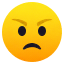

In [45]:
text = 'yellow angry'
LATENT_DIM = 512; EMBEDDING_DIM = 300
generate_image_from_text(text)

In [46]:
# Saving all the unique images generated based on the captions in the .csv file into a list gen_images as well as into the directory.
gen_images = []
for i in range(0,91,1):
  #text = 'happy'
  LATENT_DIM = 512; EMBEDDING_DIM = 300
  gen = generate_image_from_text(caption_list[i], flag = True)
  gen_images.append(gen)
  gen.save("/content/drive/MyDrive/Folder/TEST/%d.png" % i)

c = 91
for i in range(638,798,7):
  #text = 'happy'
  LATENT_DIM = 512; EMBEDDING_DIM = 300
  gen = generate_image_from_text(caption_list[i], flag = True)
  gen_images.append(gen)
  gen.save("/content/drive/MyDrive/Folder/TEST/%d.png" % c)
  c = c+1

# Image Quality Metrics

## SSIM :

In [47]:
#Calculating SSIM
scores = 0 
from skimage.metrics import structural_similarity
import cv2
for i in range(0,114,1):
  #Converting both the images to gray scale:
  gen_images[i] = img_to_array(gen_images[i])
  grayA = cv2.cvtColor(image_lists[i]*127.5+127.5, cv2.COLOR_RGB2GRAY)
  grayB = cv2.cvtColor(gen_images[i], cv2.COLOR_RGB2GRAY)
  (score, diff) = structural_similarity(grayA, grayB, full=True)
  scores = score + scores


SSIM = scores/114 #Averaging
print("The average SSIM value is : {}".format(SSIM))



The average SSIM value is : 0.7513601032061689


## PSNR : 

In [48]:
#Calculating PSNR
from math import log10, sqrt
import cv2
import numpy as np

  
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

def main():
     vals = [] 
     sum = 0
     c = 638
     for i in range(0,91,1):
        original = image_lists[i]*127.5+127.5
        compressed = gen_images[i]
        value = PSNR(original, compressed)
        vals.append(value)
     for i in range(91,114,1):
        original = image_lists[c]*127.5+127.5
        compressed = gen_images[i]
        value = PSNR(original, compressed)
        vals.append(value)
        image_list[c]
        gen_images[i]
        c = c+7


     for i in range(0,len(vals),1):
        sum = sum + vals[i]
     average = sum/114
     print(f"The average PSNR value is {average} dB")
       
if __name__ == "__main__":
    main()

The average PSNR value is 37.581393634786195 dB


Creating a list of all the Unique images and Unique Captions from the raw dataset: 

In [49]:
uniqimgs = []
path = '/content/drive/MyDrive/Folder/uniqueimages/'
for i in range(1,115,1):
  img = Image.open(path + str(i) + '.png')
  img = img.convert('RGBA')
  img = np.asarray(img).astype(np.uint8)
  uniqimgs.append(img)
#uniqimgs

In [50]:
uniqcaptions = []
path = '/content/drive/MyDrive/Folder/uniqueimages/'
for i in range(0,91,1):
  cap = caption_list[i].strip()
  uniqcaptions.append(cap)
for i in range(638,798,7):
  cap = caption_list[i]
  uniqcaptions.append(cap)


## FEATURE MATCHING: <br>
For this, we find the keypoints of the raw image and the generated image and see how many keypoints match among the two images. To find the keypoints, we use SIFT.

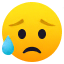

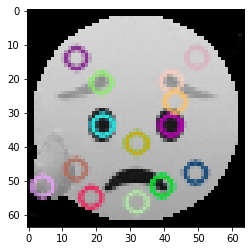

In [51]:
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline

path = '/content/drive/MyDrive/Folder/TEST/0.png'
img1 = cv2.imread(path)  
gray1 = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

sift = cv2.xfeatures2d.SIFT_create()
keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
#print(len(keypoints_1))
img_1 = cv2.drawKeypoints(gray1,keypoints_1,img1)
plt.imshow(img_1)
Image.open(path)

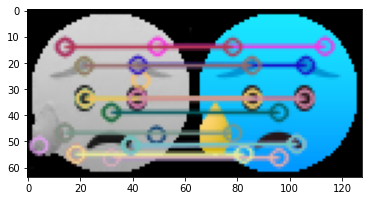

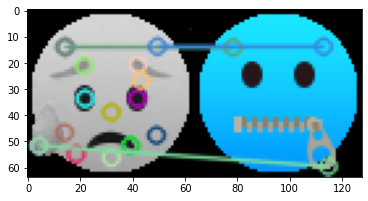

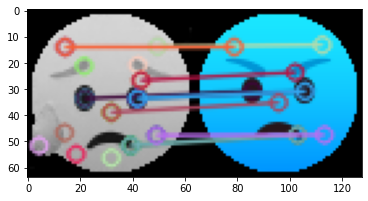

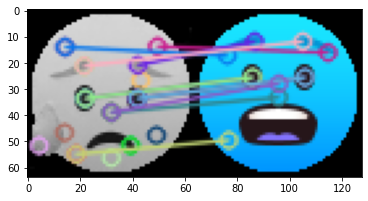

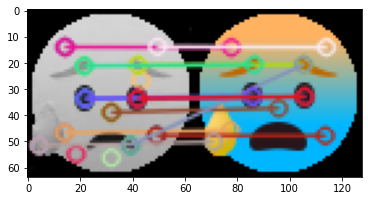

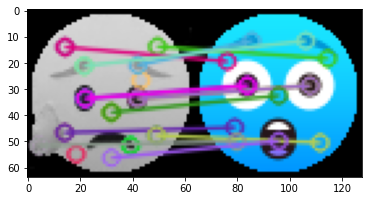

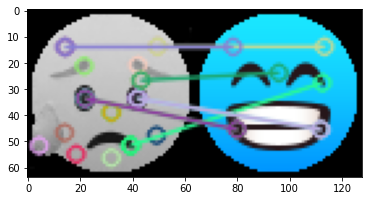

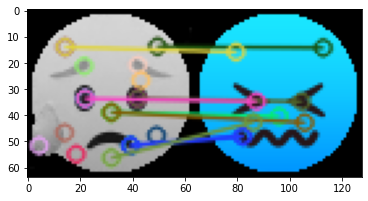

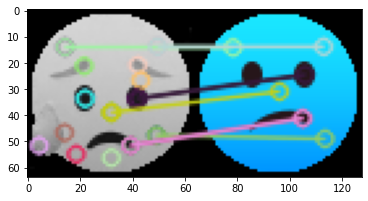

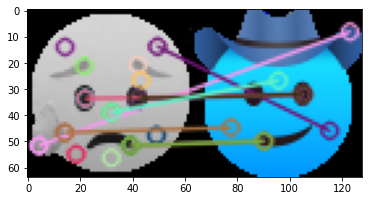

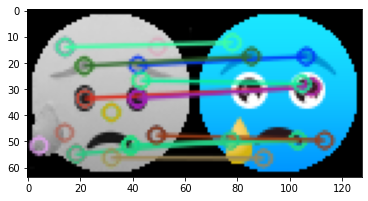

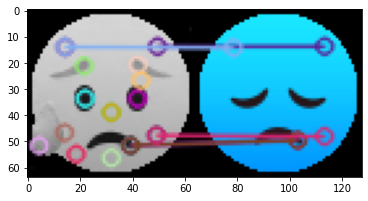

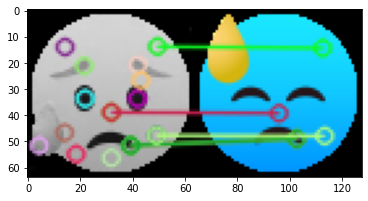

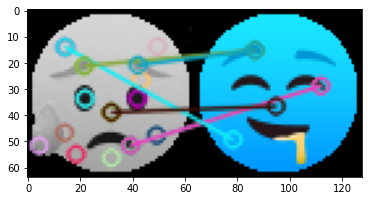

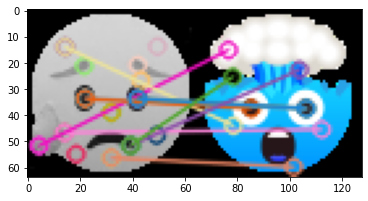

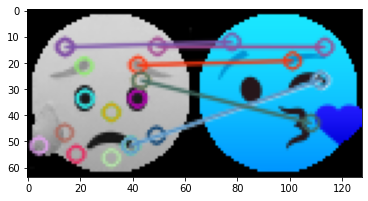

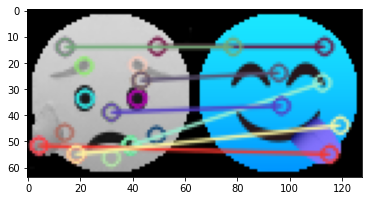

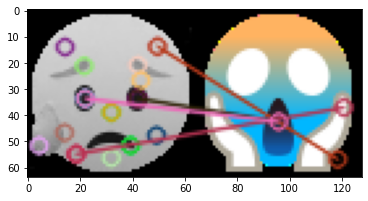

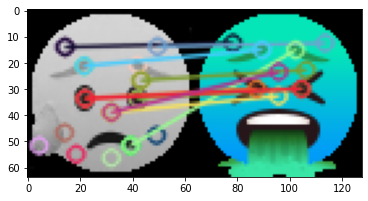

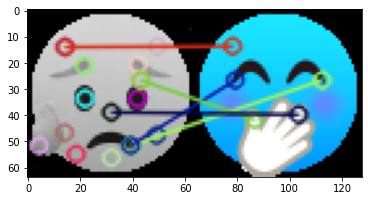

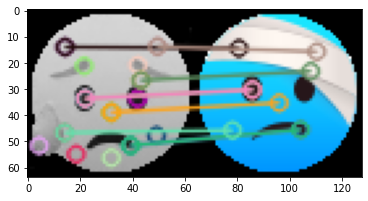

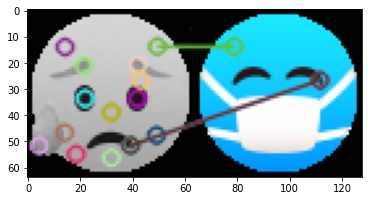

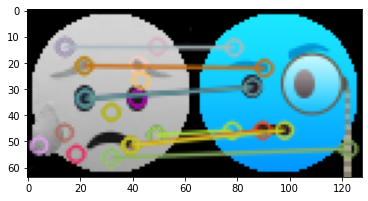

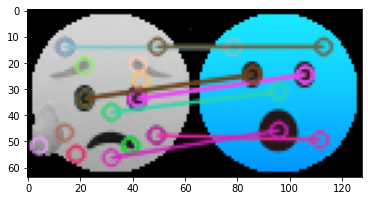

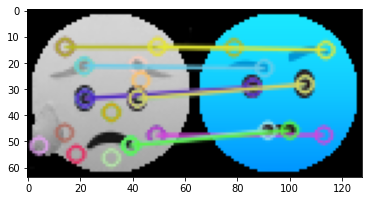

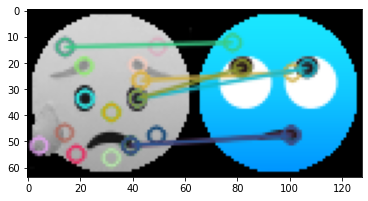

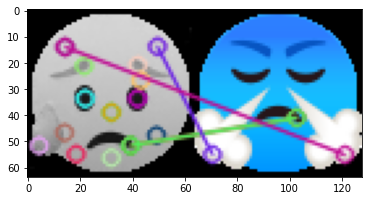

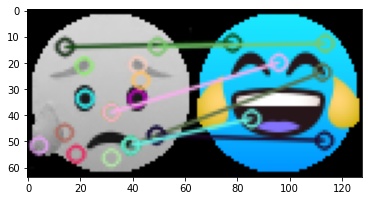

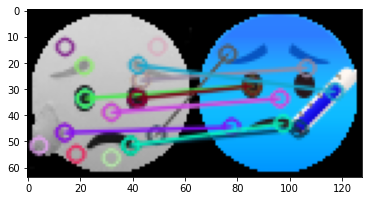

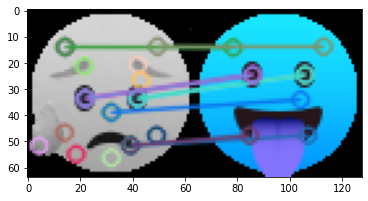

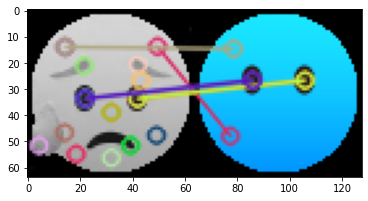

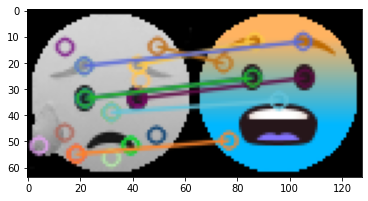

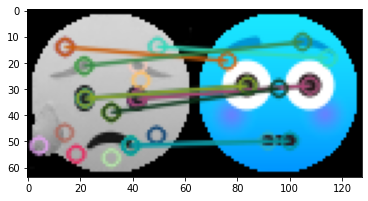

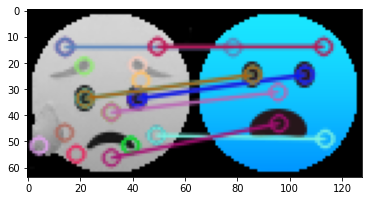

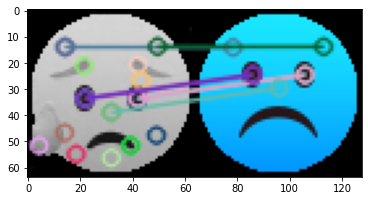

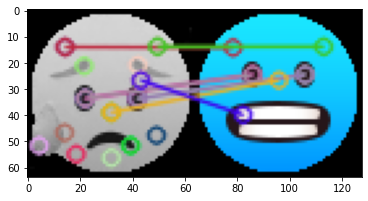

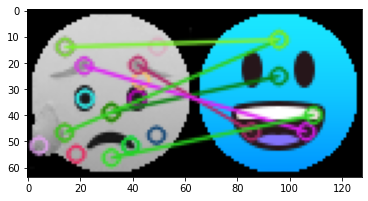

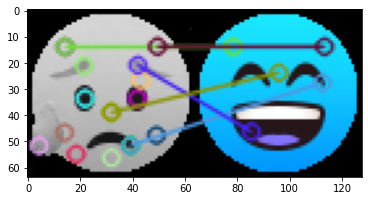

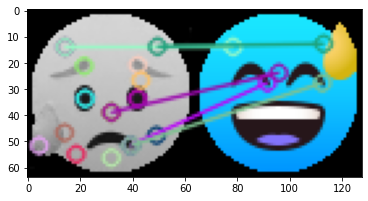

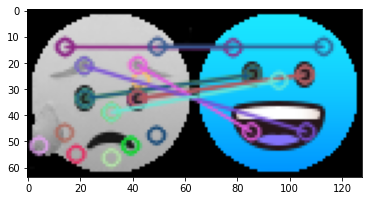

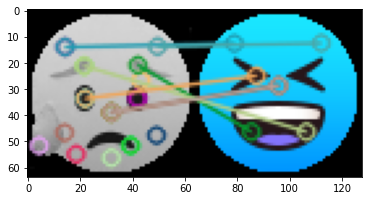

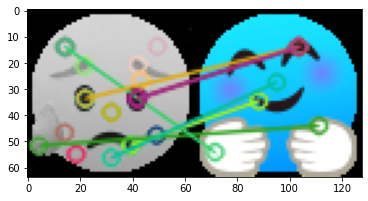

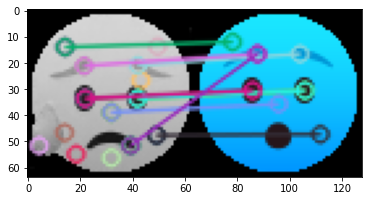

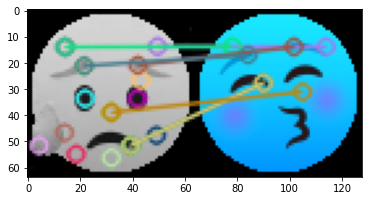

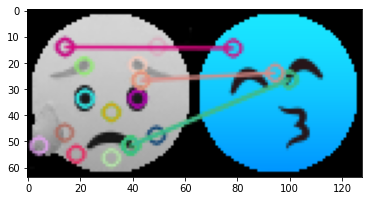

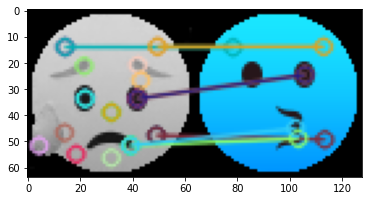

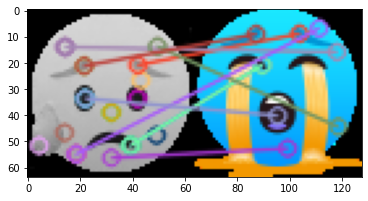

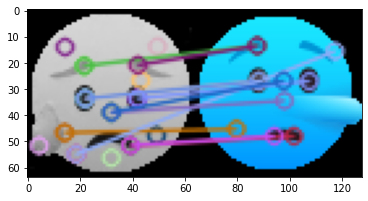

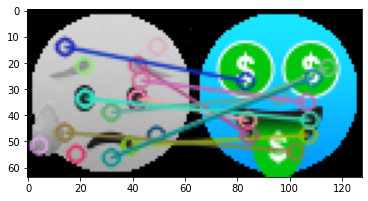

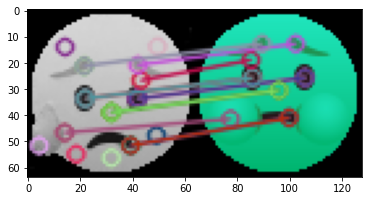

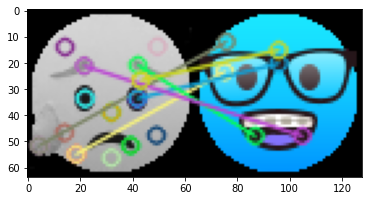

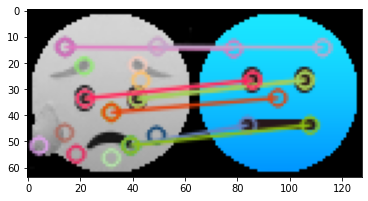

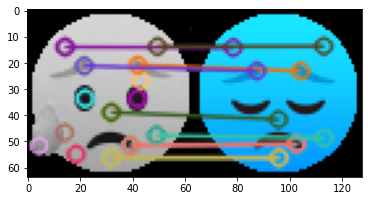

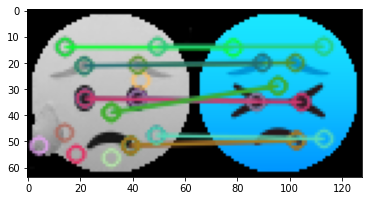

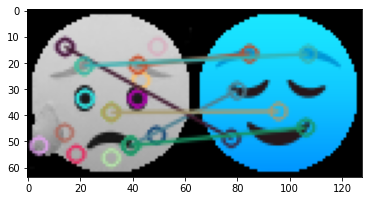

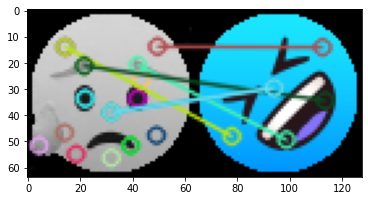

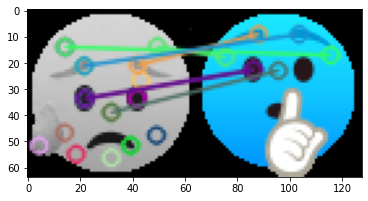

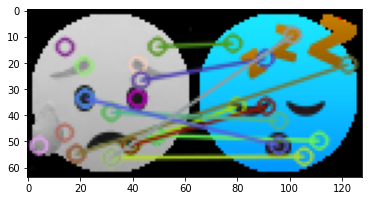

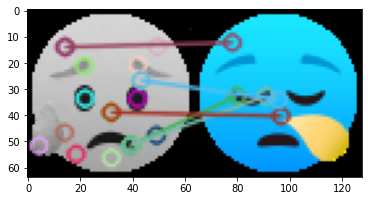

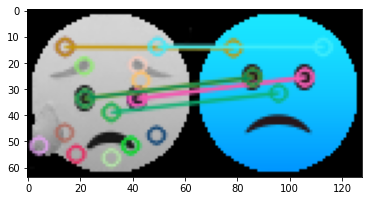

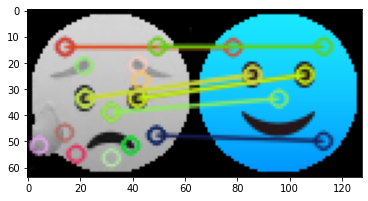

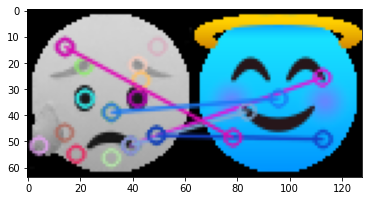

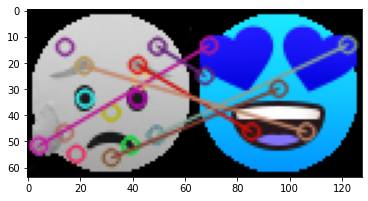

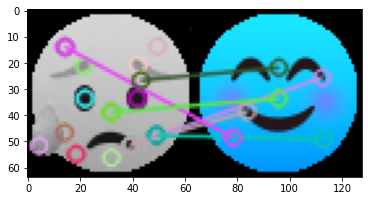

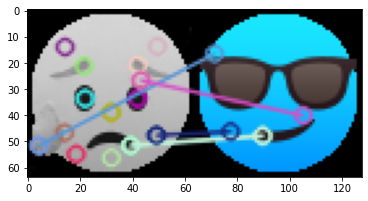

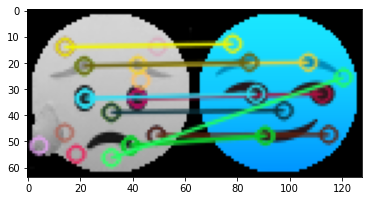

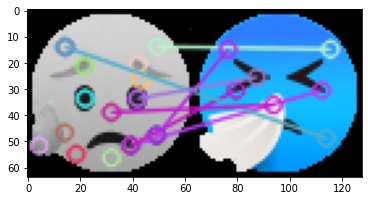

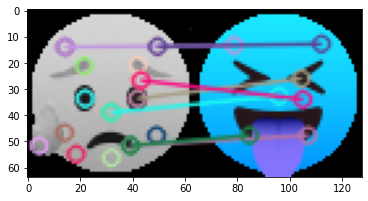

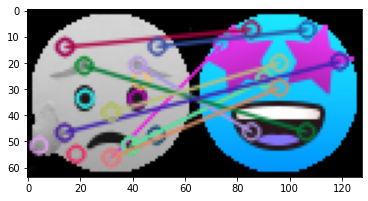

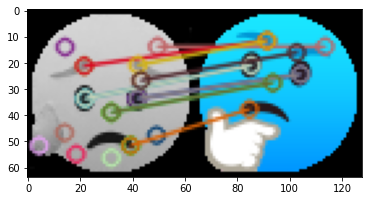

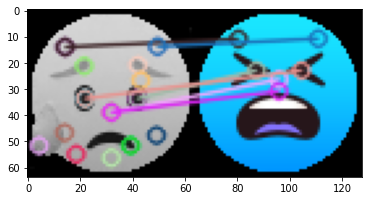

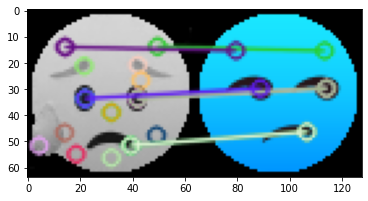

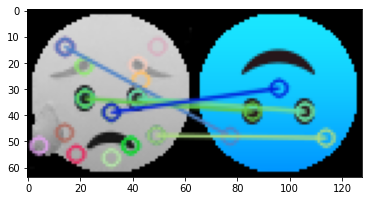

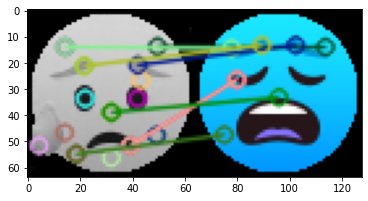

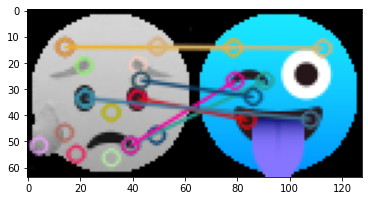

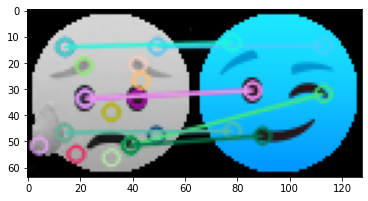

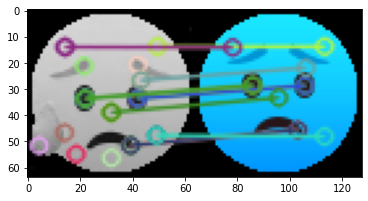

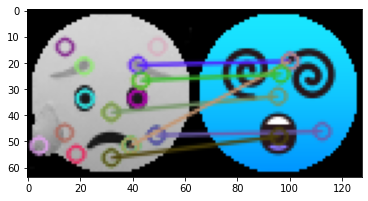

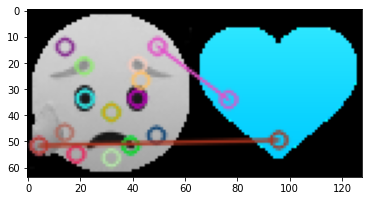

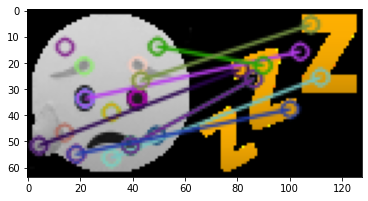

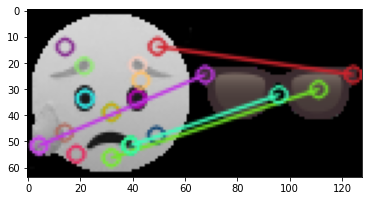

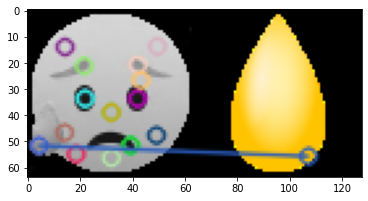

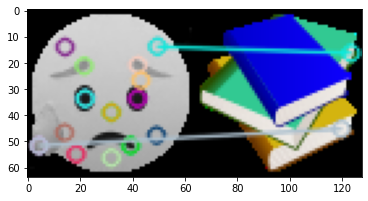

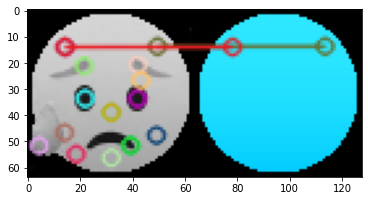

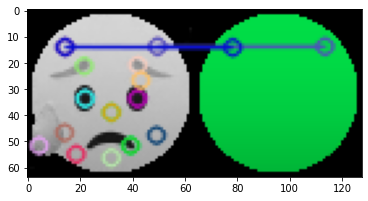

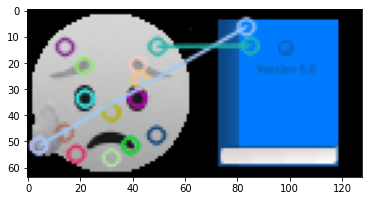

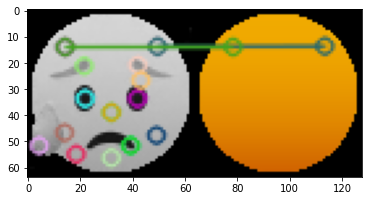

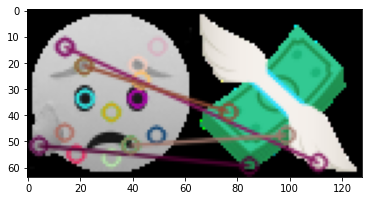

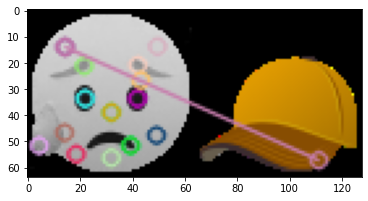

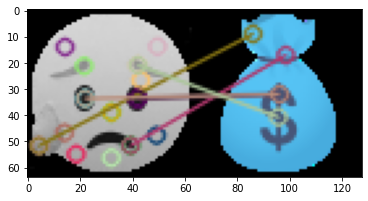

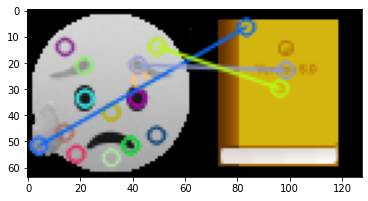

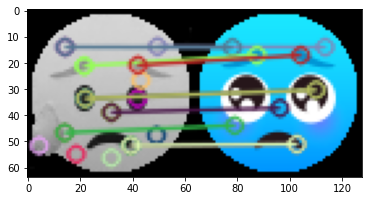

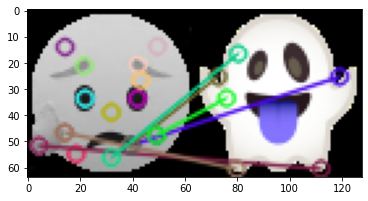

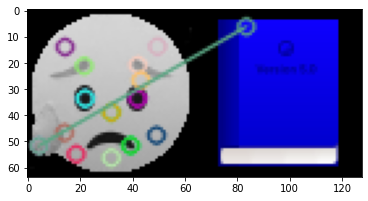

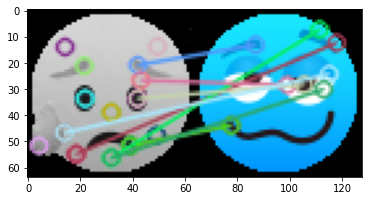

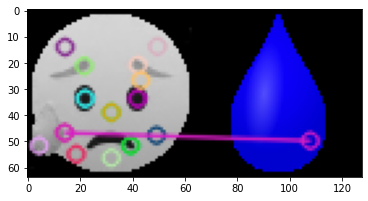

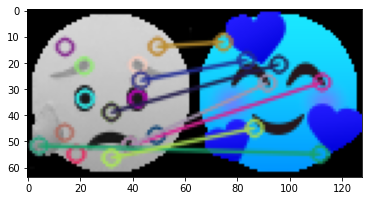

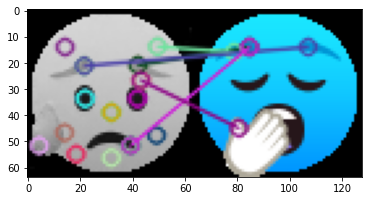

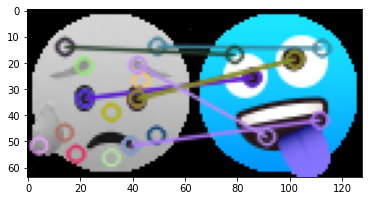

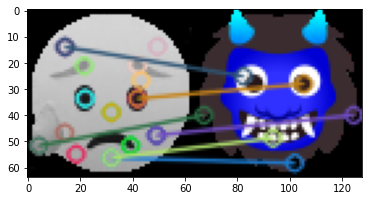

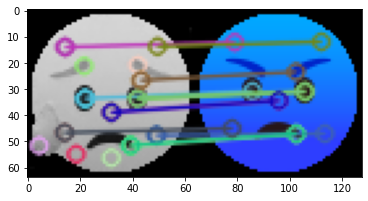

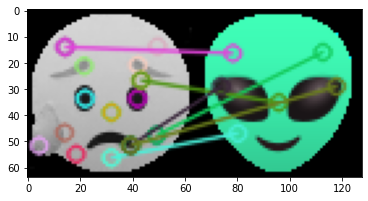

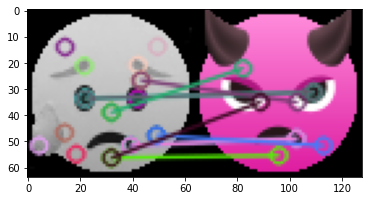

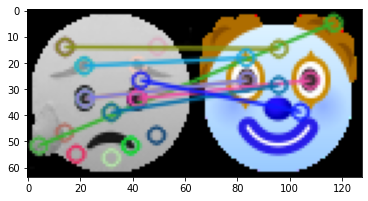

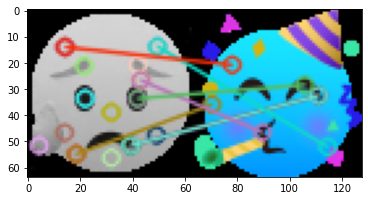

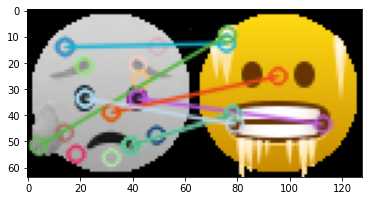

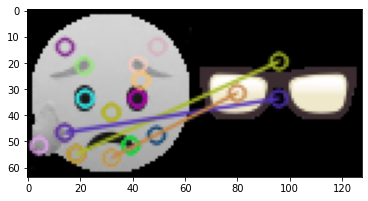

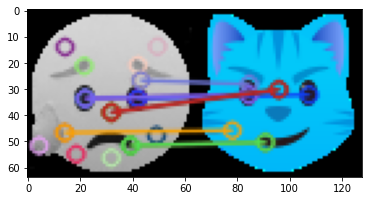

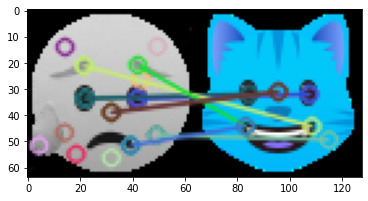

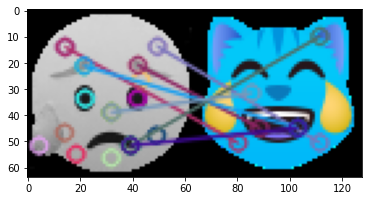

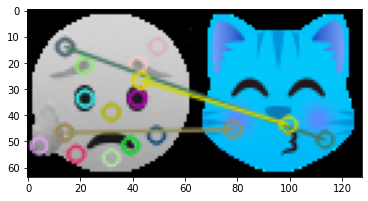

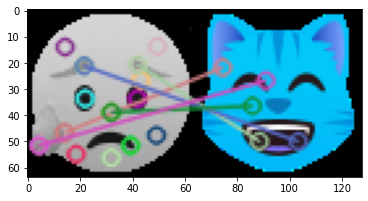

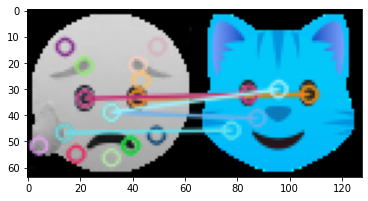

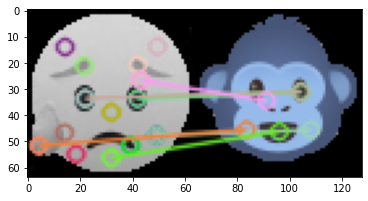

In [52]:
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline
graylist = []
imglist = []
percentages = []

path = '/content/drive/MyDrive/Folder/New/'
for i in range(1,92,1):
  img2 = cv2.imread(path + str(i) + ".png")  
  imglist.append(img2)
  gray2 = cv2.imread(path + str(i) + ".png", cv2.IMREAD_GRAYSCALE)
  graylist.append(gray2)

for i in range(638,798,7):
  img2 = cv2.imread(path + str(i) + ".png")  
  imglist.append(img2)
  gray2 = cv2.imread(path + str(i) + ".png", cv2.IMREAD_GRAYSCALE)
  graylist.append(gray2)

for i in range(0,114,1):
  sift = cv2.xfeatures2d.SIFT_create()
  keypoints_2, descriptors_2 = sift.detectAndCompute(imglist[i],None)
  #print(len(keypoints_2))
  #img_2 = cv2.drawKeypoints(graylist[i],keypoints_2,imglist[i])
  #plt.imshow(imglist[i])
  #sift
  #sift = cv2.xfeatures2d.SIFT_create()

  #keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
  #keypoints_2, descriptors_2 = sift.detectAndCompute(imglist[i],None)
  #img_2 = cv2.drawKeypoints(graylist[i],keypoints_2,imglist[i])

  #print(len(keypoints_1), len(keypoints_2))


  bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

  matches = bf.match(descriptors_1,descriptors_2)
  matches = sorted(matches, key = lambda x:x.distance)

  img3 = cv2.drawMatches(img1, keypoints_1, imglist[i], keypoints_2, matches[:50], graylist[i], flags=2)
  plt.imshow(img3),plt.show()
  #print(len(matches))
  percentage = (2*len(matches)/(len(keypoints_1) + len(keypoints_2)))*100
  percentages.append(percentage)

The percentage of similarity of the closest match is : 83.33333333333334


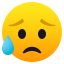

In [53]:
print("The percentage of similarity of the closest match is : " + str(max(percentages)))
index_max = max(range(len(percentages)), key=percentages.__getitem__)
path = '/content/drive/MyDrive/Folder/uniqueimages/'
Image.open(path+str(index_max + 1) + '.png')

Finding the percentage of keypoints that match among all the raw images and the generated images.

In [54]:
counter = 0
path = '/content/drive/MyDrive/Folder/TEST/'
for i in range(0,114,1):
  val = i
  img1 = cv2.imread(path + str(i) + ".png")  
  gray1 = cv2.imread(path + str(i) + ".png", cv2.IMREAD_GRAYSCALE)

  #keypoints
  sift = cv2.xfeatures2d.SIFT_create()
  keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)

  for i in range(0,114,1):
    sift = cv2.xfeatures2d.SIFT_create()
    keypoints_2, descriptors_2 = sift.detectAndCompute(imglist[i],None)
    #feature matching
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

    matches = bf.match(descriptors_1,descriptors_2)
    matches = sorted(matches, key = lambda x:x.distance)

    img3 = cv2.drawMatches(img1, keypoints_1, imglist[i], keypoints_2, matches[:50], imglist[i], flags=2)

    percentage = (2*len(matches)/(len(keypoints_1) + len(keypoints_2)))*100
    percentages.append(percentage)
  #print(max(percentages))
  print("The percentage of similarity of the closest match is : " + str(max(percentages)))
  index_max = max(range(len(percentages)), key=percentages.__getitem__)
  #print(index_max)
  if val == (index_max):
    counter = counter + 1
  else:
    counter = counter + 0
  #path = '/content/drive/MyDrive/Folder/uniqueimages/'
  #Image.open(path+str(index_max + 1) + '.png')
  percentages = []



The percentage of similarity of the closest match is : 83.33333333333334
The percentage of similarity of the closest match is : 75.0
The percentage of similarity of the closest match is : 88.88888888888889
The percentage of similarity of the closest match is : 90.32258064516128
The percentage of similarity of the closest match is : 87.5
The percentage of similarity of the closest match is : 85.1063829787234
The percentage of similarity of the closest match is : 78.26086956521739
The percentage of similarity of the closest match is : 85.24590163934425
The percentage of similarity of the closest match is : 90.0
The percentage of similarity of the closest match is : 82.05128205128204
The percentage of similarity of the closest match is : 72.72727272727273
The percentage of similarity of the closest match is : 77.77777777777779
The percentage of similarity of the closest match is : 68.75
The percentage of similarity of the closest match is : 57.89473684210527
The percentage of similarity o

In [55]:
counter

99

In [56]:
perc = (counter/114) * 100
print("The accuracy of the feature matching is: " + str(perc))

The accuracy of the feature matching is: 86.8421052631579


## TRANSFER LEARNING 

The next section uses transfer learning to convert the Discriminator we made earlier to a Multi-class Classifier.

In [57]:
image_listx = np.empty((798, 64, 64, 4))

for i in range(0,798,1):
    img = image_list[i]*127.5+127.5
    img = img.astype('uint8')
    #img = Image.fromarray(img).convert('RGBA')
    #img[img[...,-1]<=128] = [255,255,255,0]
    #print(imgresized)
    #imgresized = Image.fromarray(img.astype(np.uint8))
    #imgresized = imgresized.convert('RGB')
    #imgresized = img_to_array(imgresized)
    image_listx[i] = (img.astype(np.float32)/127.5) - 1.0


The block of code below creates an array called numbers that assigns each image with a value between 0 and 113 for the 798 images based on the captions of those images.

In [58]:
c = 91
for i in range(0,91,1):
  numbers[i] = i+1-1
for i in range(91,182,1):
  numbers[i] = i - 90-1
for i in range(182,273,1):
  numbers[i] = i - 181-1
for i in range(273,364,1):
  numbers[i] = i - 272-1
for i in range(364,455,1):
  numbers[i] = i - 363-1
for i in range(455,546,1):
  numbers[i] = i - 454-1
for i in range(546,637,1):
  numbers[i] = i - 545-1
for i in range(637,798,7):
  numbers[i] = c
  numbers[i+1] = c
  numbers[i+2] = c
  numbers[i+3] = c
  numbers[i+4] = c
  numbers[i+5] = c
  numbers[i+6] = c
  c = c+1

In [59]:
numbers

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  8

In [60]:
#Splitting into Training and Test Set.
from sklearn.model_selection import train_test_split
image_train,image_test,caption_train,caption_test,numbers_train,numbers_test = train_test_split(image_listx, caption_list, numbers, test_size = 0.033)

In [61]:
c = 1
value = np.where(numbers_train == 113)
vals = value[0][0]

In [62]:
if 113 not in numbers_test: 
      val = numbers_test[26]
      numbers_test[26] = numbers_train[vals]
      numbers_train[vals] = val
      img = image_test[26]
      image_test[26] = image_train[vals]
      image_train[vals] = img
      cap = caption_test[26]
      caption_test[26] = caption_train[vals]
      caption_train[vals] = cap

In [63]:
113 in numbers_test

True

Loading the discriminator model: 

In [64]:
from keras.models import model_from_json
with open("/content/drive/MyDrive/Folder/model.json") as json_file:
    model = model_from_json(json_file.read())
    model.load_weights("/content/drive/MyDrive/Folder/Discriminator-weights/discriminator_weights_980.h5")

Setting layers.trainable to False for the first 14 layers and then popping the last two layers and adding 3 new layers where the last layer has 114 neurons for each of the 114 classes.

In [65]:
for i in range(14):
    model.layers[i].trainable = False

In [66]:
ll = model.layers[14].output
l1 = model.layers.pop()
l1 = model.layers.pop()
#ll = Dense(128)(ll)
ll = Dense(114,activation="softmax")(ll)

new_model = Model(inputs=model.input,outputs=ll)
new_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 4)]  0           []                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 32, 32, 128)  4736        ['input_3[0][0]']                
                                                                                                  
 leaky_re_lu_6 (LeakyReLU)      (None, 32, 32, 128)  0           ['conv2d_7[0][0]']               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 16, 16, 256)  295168      ['leaky_re_lu_6[0][0]']          
                                                                                            

In [67]:
new_model.compile()

In [68]:
new_model.layers[-1].weights

[<tf.Variable 'dense_4/kernel:0' shape=(295936, 114) dtype=float32, numpy=
 array([[-0.00428382,  0.00233831, -0.00126069, ..., -0.00174639,
         -0.004194  , -0.00101469],
        [-0.00094999, -0.00253783, -0.0043799 , ...,  0.00019872,
          0.00363314, -0.00096203],
        [ 0.00191149, -0.00079549,  0.00018353, ..., -0.00063047,
          0.00212119,  0.00154158],
        ...,
        [-0.00061356, -0.0010241 , -0.00439646, ..., -0.00372919,
         -0.00379212, -0.00166529],
        [ 0.00291821, -0.00038819, -0.00420939, ...,  0.00055384,
          0.00399089,  0.00024406],
        [ 0.00376104,  0.00260962,  0.00264384, ...,  0.00071191,
          0.00111616, -0.00242313]], dtype=float32)>,
 <tf.Variable 'dense_4/bias:0' shape=(114,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [69]:
image_train.shape

(771, 64, 64, 4)

In [70]:
numbers_train.shape

(771,)

Vectorizing all the captions and converting all the Image IDs (0 to 113) to a binary class matrix. Then we compile the model which has 2 inputs, the image and the caption and then predicts the Image ID.

In [71]:
from tensorflow.keras.utils import to_categorical
train_labels = vectorize_sent_list(caption_train)
test_labels = vectorize_sent_list(caption_test)
output_train_labels = to_categorical(numbers_train, num_classes = 114)
output_test_labels = to_categorical(numbers_test, num_classes = 114)

In [72]:
# UNCOMMENT TO TRAIN CLASSIFICATION MODEL OR RUN NEXT CELL TO LOAD SAVED WEIGHTS
#new_model.compile(optimizer='adam',
#                  loss='categorical_crossentropy',
#                  metrics=['accuracy'])

#history = new_model.fit([image_train, train_labels], output_train_labels, batch_size=100, epochs=1,validation_data=([image_test, test_labels], output_test_labels))
#model_json = new_model.to_json()
#with open("/content/drive/MyDrive/Folder/classificationmodel.json", "w") as json_file:
#        json_file.write(model_json)
#new_model.save_weights('/content/drive/MyDrive/Folder/classification_model_weights.h5')

In [73]:
from keras.models import model_from_json
with open("/content/drive/MyDrive/Folder/classificationmodel.json") as json_file:
    model = model_from_json(json_file.read())
    model.load_weights("/content/drive/MyDrive/Folder/classification_model_weights.h5")

In [74]:
image_train.shape

(771, 64, 64, 4)

In [75]:
output_test_labels.shape

(27, 114)

The image we are trying to classify is: 


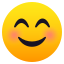

[[1.79030376e-05 9.64931911e-04 2.35669766e-04 1.06626656e-03
  3.41126753e-04 1.37712312e-04 4.92851017e-04 6.86937128e-05
  4.44817451e-05 6.38204219e-05 8.83127213e-05 7.12761030e-05
  6.24448410e-04 3.31168325e-04 1.05710809e-04 3.55731958e-04
  4.51544474e-05 3.03564866e-05 4.25493818e-05 1.15612755e-03
  2.89079006e-04 4.31660970e-04 3.51372233e-04 1.11065776e-04
  1.12405594e-03 2.37399014e-04 6.03236585e-05 1.10966474e-04
  6.72341674e-04 1.28516867e-05 7.68220925e-05 1.84678094e-04
  7.95586617e-04 1.01987517e-03 2.14940432e-04 1.14517105e-04
  7.70601328e-04 1.97619273e-04 6.57885859e-04 8.99186882e-04
  3.77753677e-05 1.49790110e-04 5.53458631e-05 2.30706437e-03
  7.84141128e-04 5.36811240e-05 2.33443716e-05 3.98382108e-04
  1.10116060e-04 1.37180305e-05 1.51857021e-04 4.49154613e-04
  2.81038112e-04 6.05272508e-05 5.97757054e-04 6.97982468e-05
  2.61293535e-05 3.18673156e-05 3.64371488e-04 1.18895798e-04
  1.72083755e-03 3.69879440e-03 4.59208706e-04 9.60838795e-01
  3.6313

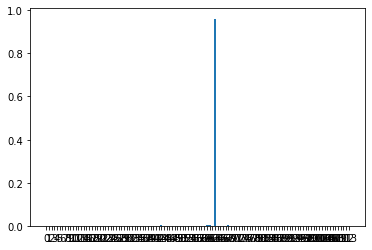

In [76]:
# Demonstration: predict a Test Digit: (RAW IMAGE)
i = 1
prediction = model.predict([image_test[i].reshape(1,64,64,4), test_labels[i].reshape(1,300)])

# get probability distribution and classification of the test digit
print("The image we are trying to classify is: ")
img = Image.fromarray((image_test[i]*127.5+127.5).astype('uint8'))
display(img.resize((64,64), PIL.Image.LANCZOS))
print(prediction)
print('prediction:', np.argmax(prediction))
print('The predicted text is : ' + caption_test[i])

# draw the barplot
plt.figure()
plt.bar(np.arange(0,114).astype('str'), prediction[0,:])
plt.show()

Creating an array that consists of arrays of all the generated images that have been normalized to values between -1 and 1.

In [77]:
gen_imagesx = np.empty((114, 64, 64, 4))

for i in range(0,114,1):
    img = gen_images[i]
    img = img.astype('uint8')
    #img = Image.fromarray(img).convert('RGBA')
    #img[img[...,-1]<=128] = [255,255,255,0]
    #print(imgresized)
    #imgresized = Image.fromarray(img.astype(np.uint8))
    #imgresized = imgresized.convert('RGB')
    #imgresized = img_to_array(imgresized)
    gen_imagesx[i] = (img.astype(np.float32)/127.5) - 1.0


List of Unique Captions: 

In [78]:
captionsx = []
for i in range(0,91,1):
  captionsx.append(caption_list[i])
for i in range(638,798,7):
  captionsx.append(caption_list[i])
captions = np.array(captionsx)

Vectorizing the array of captions: 

In [79]:
cap = vectorize_sent_list(captions)

## Classifying the Generated Images: 

The image we are trying to classify is: 


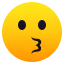

[[1.30602566e-03 2.25637015e-02 4.59377840e-03 2.03385148e-02
  4.58598696e-03 2.96070264e-03 7.59214628e-03 1.53775862e-03
  2.31442624e-03 2.81055598e-03 3.36805638e-03 2.72499071e-03
  1.47587406e-02 6.51983265e-03 2.15657568e-03 2.06337161e-02
  1.61712035e-03 3.69840534e-04 3.45540262e-04 6.83897827e-03
  1.12622799e-02 8.69194046e-03 3.80517612e-03 6.21238630e-03
  1.12622539e-02 7.52612017e-03 2.77182856e-03 1.45495997e-03
  1.33050438e-02 7.20171316e-04 2.74524512e-03 3.63770523e-03
  1.40400343e-02 1.53588261e-02 1.18328081e-02 1.00231795e-02
  1.35145234e-02 7.05928076e-04 3.86731839e-03 3.12532708e-02
  8.61704408e-04 3.10454215e-03 3.03527736e-03 1.57277135e-03
  1.78385973e-02 3.39997858e-01 4.08978114e-04 7.33812526e-03
  1.03881198e-03 5.34801686e-04 2.15735449e-03 9.49170347e-03
  4.92164632e-03 9.77343763e-04 1.25175780e-02 1.63014093e-03
  9.18139878e-04 2.24670628e-03 8.44763592e-03 7.09199905e-03
  3.44887711e-02 1.33546665e-02 3.42884799e-03 4.67167702e-03
  4.3426

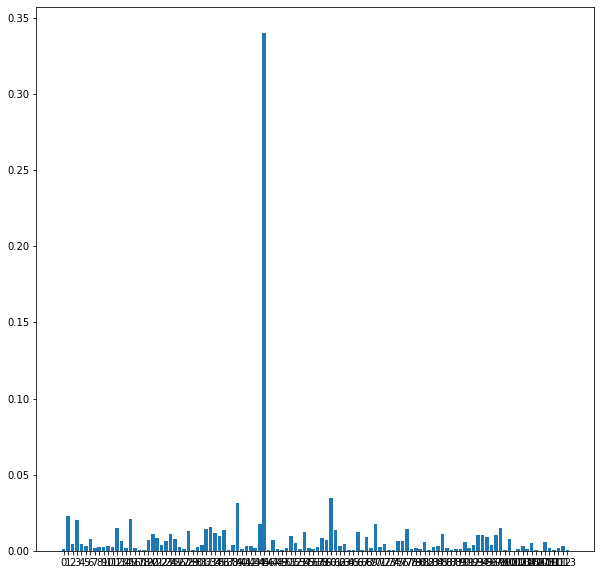

In [80]:
i = 45
prediction = model.predict([gen_imagesx[i].reshape(1,64,64,4), cap[i].reshape(1,300)])

# get probability distribution and classification of the test digit
print("The image we are trying to classify is: ")
img = Image.fromarray((gen_imagesx[i]*127.5+127.5).astype('uint8'))
display(img.resize((64,64), PIL.Image.LANCZOS))
print(prediction)
print('The prediction is :', np.argmax(prediction))
print('The predicted text is : ' + captionsx[i])

# draw the barplot
plt.figure(figsize = (10,10))
plt.bar(np.arange(0,114).astype('str'), prediction[0,:])
plt.show()

# UI for Text to Image Synthesis

In [81]:
pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 2.1 MB/s 
     |████████████████████████████████| 84 kB 3.4 MB/s 
     |████████████████████████████████| 2.3 MB 86.3 MB/s 
     |████████████████████████████████| 55 kB 4.5 MB/s 
     |████████████████████████████████| 84 kB 4.3 MB/s 
     |████████████████████████████████| 212 kB 101.5 MB/s 
     |████████████████████████████████| 112 kB 89.4 MB/s 
     |████████████████████████████████| 57 kB 5.7 MB/s 
     |████████████████████████████████| 54 kB 3.9 MB/s 
     |████████████████████████████████| 270 kB 93.5 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 80 kB 8.2 MB/s 
     |████████████████████████████████| 68 kB 7.9 MB/s 
     |████████████████████████████████| 43 kB 2.4 MB/s 
     |████████████████████████████████| 594 kB 58.3 MB/s 
     |████████████████████████████████| 856 kB 70

In [82]:
import gradio as gr
caps = vectorize_sent_list(uniqcaptions)
def bilateralfilter(img):
        newData = np.empty((64,64,4))
        #img[img[...,-1]<=128] = [255,255,255,0]
        img = Image.fromarray(img.astype('uint8'))
        img = img.convert('RGB')
        img = img_to_array(img)
        img = cv2.bilateralFilter(img,11, 21, 7)
        img = Image.fromarray(img.astype('uint8'))
        img = img.convert('RGBA')
        img = img_to_array(img).astype('uint8')
        width = 64
        height = 64
        for x in range(0,width):# process all pixels
           for y in range(0,height):
              datas = img[x,y]
              if (datas[0] <= 5 and datas[1] <= 5 and datas[2] <= 5 ):
                img[x,y] = [255,255,255,0]
        return img

def key_perc(img_11,img_22):
    img1 = cv2.imread(img_11)  
    gray1 = cv2.imread(img_11, cv2.IMREAD_GRAYSCALE)

    #keypoints
    sift = cv2.xfeatures2d.SIFT_create()
    keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
    #print(len(keypoints_1))
    img_1 = cv2.drawKeypoints(gray1,keypoints_1,img1)

    img2 = cv2.imread(img_22)  
    gray2 = cv2.imread(img_22, cv2.IMREAD_GRAYSCALE)

    sift = cv2.xfeatures2d.SIFT_create()
    keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

    matches = bf.match(descriptors_1,descriptors_2)
    matches = sorted(matches, key = lambda x:x.distance)

    img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:50], img2, flags=2)

    percentage = (2*len(matches)/(len(keypoints_1) + len(keypoints_2)))*100
    return percentage


def SSIM(img_1,img_2):
  scores = 0 
  #Converting both the images to gray scale:
  grayA = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
  grayB = cv2.cvtColor(img_2, cv2.COLOR_RGB2GRAY)
  (score, diff) = structural_similarity(grayA, grayB, full=True)
  scores = score + scores
  return scores
  

def generate_image_from_texts(text, flag=True):
    ### prepare an empty array
    noise = np.zeros(shape=(1, LATENT_DIM))
    encoded_text = np.zeros(shape=(1, EMBEDDING_DIM))

    ### generate sample for input data
    text = text.lower()
    regex_any_symbol = re.compile("[!-/:-@[-`{-~]")
    text = re.sub(regex_any_symbol, "", text)
    text = text.strip()
    encoded_text[0, :] = vectorize_sentence(text)
    noise[0, :] = np.random.uniform(0, 1, LATENT_DIM)

    ### predict and generate an image
    generated_images = generator.predict([noise, encoded_text])
    generated_image = generated_images[0]
    index = 0
    if text in uniqcaptions:
          index = index + uniqcaptions.index(text)
          image = uniqimgs[index]
          generated_image = generated_image * 127.5 + 127.5
          img =  Image.fromarray(generated_image.astype(np.uint8)).convert('RGBA')
          img = img_to_array(img)
          #imgs = cv2.medianBlur(img,3)
          #imgs = cv2.blur(img,(3,3))
          #imgs = cv2.GaussianBlur(img,(3,3),0)
          #imgs = bilateralfilter(img)
          realimage = Image.fromarray(image.astype(np.uint8)).convert('RGBA')
          #syntheticimagedisplay = Image.fromarray(imgs.astype('uint8'))
          syntheticimage = Image.fromarray(img.astype('uint8'))
          realimage.save("/content/drive/MyDrive/Folder/realimg.png")
          syntheticimage.save("/content/drive/MyDrive/Folder/synthimg.png")
          scores = SSIM(img, image)
          percentage = key_perc("/content/drive/MyDrive/Folder/synthimg.png", "/content/drive/MyDrive/Folder/realimg.png")
          img = img/127.5 - 1.0
          prediction = model.predict([img.reshape(1,64,64,4), caps[index].reshape(1,300)])
          # get probability distribution and classification of the test digit
          max = uniqcaptions[np.argmax(prediction)]
          return realimage , uniqcaptions[index], syntheticimage , max, scores , percentage
    else: 
          percentage = 0
          scores = 0
          uniqcaptionsactual = 'NIL'
          max = 'NIL'
          generated_image = generated_image * 127.5 + 127.5
          img =  Image.fromarray(generated_image.astype(np.uint8)).convert('RGBA')
          img = img_to_array(img)
          #imgs = cv2.medianBlur(img,3)
          #imgs = cv2.blur(img,(3,3))
          #imgs = cv2.GaussianBlur(img,(3,3),0)
          #imgs = bilateralfilter(img)
          #syntheticimagedisplay = Image.fromarray(imgs.astype('uint8'))
          syntheticimage = Image.fromarray(img.astype('uint8'))
          return Image.open('/content/drive/MyDrive/Folder/filedoesnotexist.png'), uniqcaptionsactual, syntheticimage, max, scores , percentage
 
      

demo = gr.Blocks()

with demo:
    gr.Markdown(
        """
    # Text to Emoji Synthesis
    Start typing below to see the output.
    """
    )
    with gr.Tabs():
      with gr.TabItem("Emoji Synthesis"):
        input = gr.Textbox(placeholder="Type your Caption", label = "Text")
        with gr.Row():
          output = [gr.Image(label="Raw Image"),gr.Text(label="Actual Caption"),gr.Image(label="Synthetic"),gr.Text(label="Classification"),gr.Number(label='SSIM'),gr.Number(label='Percentage of matching keypoints')]
        emoji_button = gr.Button("Generate Emoji!")
    #input.change(fn=generate_image_from_texts, inputs=input, outputs=output)
    emoji_button.click(generate_image_from_texts, inputs=input, outputs=output)

demo.launch()


Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://10765.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x7f810a79a090>,
 'http://127.0.0.1:7860/',
 'https://10765.gradio.app')

# GAN EVALUATION METRICS

## Inception Score using Transfer Learning

In [83]:
uniqimgss = np.empty((114,64,64,4))
for i in range(0,114,1):
  conv = uniqimgs[i]/127.5 - 1.0
  uniqimgss[i] = conv

r_batch = np.empty((114,1,114))
def inception_score(x, c):
    r = None
    r_batch = model.predict([x.reshape(114,64,64,4), c.reshape(114,300)]) 
    r = r_batch if r is None else np.concatenate([r, r_batch], axis=0)
    p_y = np.mean(r, axis=0) 
    e = r * np.log(r / p_y) 
    e = np.sum(e, axis=1) 
    e = np.mean(e, axis=0)
    return np.exp(e) 

if __name__ == '__main__':
    scores = []

    generated_score = inception_score(gen_imagesx, cap)
    scores.append([generated_score])
    print('Generated score: {0}'.format(generated_score))
        
    df = pd.DataFrame(scores, columns=['generated'])
    df.to_csv('/content/drive/MyDrive/Folder/saved_model/inception_gan.csv', mode='a', header=False)



Generated score: 20.26453399658203


##Fréchet Inception Distance using Transfer Learning

In [84]:
for i in range(14):
    new_model.layers[i].trainable = False

In [85]:
from keras.layers import GlobalAveragePooling2D
ll = new_model.layers[14].output
ll = Dense(1024)(ll)
new_modelfid = Model(inputs=new_model.input,outputs=ll)
new_modelfid.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 4)]  0           []                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 32, 32, 128)  4736        ['input_3[0][0]']                
                                                                                                  
 leaky_re_lu_6 (LeakyReLU)      (None, 32, 32, 128)  0           ['conv2d_7[0][0]']               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 16, 16, 256)  295168      ['leaky_re_lu_6[0][0]']          
                                                                                            

In [86]:
def compute_embeddings(x, c):
    image_embeddings = []

    for i in range(114):
        embeddings = new_modelfid.predict([x.reshape(114,64,64,4), c.reshape(114,300)])
        image_embeddings.append(embeddings)

    return np.array(image_embeddings)

# compute embeddings for real images
real_image_embeddings = compute_embeddings(uniqimgss, vectorize_sent_list(uniqcaptions))

# compute embeddings for generated images
generated_image_embeddings = compute_embeddings(gen_imagesx, cap)
real_image_embeddings.shape, generated_image_embeddings.shape

((114, 114, 1024), (114, 114, 1024))

In [87]:
real_image_embeddings = real_image_embeddings.reshape(12996,1024)
generated_image_embeddings = generated_image_embeddings.reshape(12996,1024)
real_image_embeddings.shape, generated_image_embeddings.shape

((12996, 1024), (12996, 1024))

In [88]:
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
def calculate_fid(real_embeddings, generated_embeddings):

	mu1, sigma1 = real_image_embeddings.mean(axis=0), cov(real_image_embeddings, rowvar=False)
	mu2, sigma2 = generated_image_embeddings.mean(axis=0), cov(generated_image_embeddings, rowvar=False)

	ssdiff = np.sum((mu1 - mu2)**2.0)

	covmean = sqrtm(sigma1.dot(sigma2))

	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

calculate_fid(real_image_embeddings, generated_image_embeddings)

0.009809628882116762

## Inception Score Using Inception V3 Model 

In [89]:
from pathlib import Path
import sys
import numpy as np
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
from PIL import Image as pil_image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from nltk.tokenize import sent_tokenize
import re
import pandas as pd

In [90]:
modelk = InceptionV3() # Load a model and its weights

def inception_score(x, batch_size=27):
    r = None
    n_batch = (x.shape[0] + batch_size - 1) // batch_size
    for j in range(n_batch):
        x_batch = x[j * batch_size:(j + 1) * batch_size, :, :, :]
        r_batch = modelk.predict(preprocess_input(x_batch)) # r has the probabilities for all classes
        r = r_batch if r is None else np.concatenate([r, r_batch], axis=0)
    p_y = np.mean(r, axis=0) # p(y)
    e = r * np.log(r / p_y) # p(y|x)log(P(y|x)/P(y))
    e = np.sum(e, axis=1) # KL(x) = Σ_y p(y|x)log(P(y|x)/P(y))
    e = np.mean(e, axis=0)
    return np.exp(e) # Inception score


def resize(x):
    x_list = []
    for i in range(x.shape[0]):
        img = image.array_to_img(x[i, :, :, :].reshape(64, 64, -1))
        img = img.resize(size=(299, 299), resample=pil_image.LANCZOS)
        x_list.append(image.img_to_array(img))
    return np.array(x_list).astype('float32')/127.5


def dataset_inception(x_train):
    imagefinal = np.empty((114, 64, 64, 3))
    for i in range(0,114,1):
        x_train[i][x_train[i][...,-1]<=128] = [255,255,255,0]
        imgresized = Image.fromarray(x_train[i].astype(np.uint8))
        imgresized = imgresized.convert('RGB')
        #print(imgresized.size)
        imgresized = image.img_to_array(imgresized)
        imagefinal[i-1] = imgresized


    imagefinal = np.array(imagefinal)
    return inception_score(resize(imagefinal))

def output_inception_gan(caption):
  for caption in caption_train:
    _images = []
    genimgs = []
    generated_image = generate_image_from_text(caption ,flag=False)
    _images.append(generated_image)
    for i in range(0,len(_images),1):
        _images[i][_images[i][...,-1]<=128] = [255,255,255,0]
        imgresized = Image.fromarray(_images[i].astype(np.uint8))
        imgresized = imgresized.convert('RGB')
        #print(imgresized.size)
        imgresized = image.img_to_array(imgresized)
        genimgs.append(imgresized)

    
  return inception_score(resize(np.asarray(genimgs)))


if __name__ == '__main__':
    scores = []

    generated_score = output_inception_gan(caption_train)
    scores.append([generated_score])
    print('Generated score: {0}'.format(generated_score))
        
    df = pd.DataFrame(scores, columns=['generated'])
    df.to_csv('/content/drive/MyDrive/Folder/saved_model/inception_gan.csv', mode='a', header=False)



96124928/96112376 [==============================] - 1s 0us/step
Generated score: 1.0


## Fréchet Inception Distance Using InceptionV3 Model

In [91]:
from keras.applications.inception_v3 import InceptionV3
model2 = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

87924736/87910968 [==============================] - 3s 0us/step


In [92]:
model2.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_104 (Conv2D)            (None, 149, 149, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_104 (Batch  (None, 149, 149, 32  96         ['conv2d_104[0][0]']             
 Normalization)                 )                                                      

In [93]:
# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)

In [94]:
gen_resized = np.empty((114,64,64,3))
for i in range(0,114,1):
    img = gen_imagesx[i]*127.5+127.5
    img = img.astype('uint8')
    #img = Image.fromarray(img).convert('RGBA')
    img[img[...,-1]<=128] = [255,255,255,0]
    #print(imgresized)
    imgresized = Image.fromarray(img.astype(np.uint8))
    imgresized = imgresized.convert('RGB')
    imgresized = img_to_array(imgresized)
    gen_resized[i] = (imgresized.astype(np.float32)/127.5) - 1.0

uniq_resized = np.empty((114,64,64,3))
for i in range(0,114,1):
    img = uniqimgs[i]*127.5+127.5
    img = img.astype('uint8')
    #img = Image.fromarray(img).convert('RGBA')
    img[img[...,-1]<=128] = [255,255,255,0]
    #print(imgresized)
    imgresized = Image.fromarray(img.astype(np.uint8))
    imgresized = imgresized.convert('RGB')
    imgresized = img_to_array(imgresized)
    uniq_resized[i] = (imgresized.astype(np.float32)/127.5) - 1.0


In [95]:
from skimage.transform import resize
from numpy import asarray
gen_resized = scale_images(gen_resized,(299,299,3))
uniqimgsresized = scale_images(uniq_resized,(299,299,3))

In [96]:
real_image_embeddings = model2.predict(uniqimgsresized)
generated_image_embeddings = model2.predict(gen_resized)

In [97]:
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
def calculate_fid(real_embeddings, generated_embeddings):
     # calculate mean and covariance statistics
     # calculate mean and covariance statistics
	mu1, sigma1 = real_image_embeddings.mean(axis=0), cov(real_image_embeddings, rowvar=False)
	mu2, sigma2 = generated_image_embeddings.mean(axis=0), cov(generated_image_embeddings, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = np.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

calculate_fid(real_image_embeddings, generated_image_embeddings)

380.8917421009432

## CAPTION LOSS USING TRANSFER LEARNING

In [98]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Model
from keras.layers import Flatten, Dense, LSTM, Dropout, Embedding, Activation
from keras.layers import concatenate, BatchNormalization, Input
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import cv2
import string
import time

In [99]:
from keras.preprocessing.image import img_to_array
import cv2
path = '/content/drive/MyDrive/Folder/New/'
def loadImages(path):
    files = os.listdir(path)
    loadedImages = []
    for i in range(1,799,1):
        name = str(i)+'.png'
        img = Image.open(path + name)
        img = img.convert('RGBA')
        #Resizing the images to 64x64 and storing in an array
        new_width  = 64
        new_height = 64
        imgresized = img.resize((new_width, new_height), Image.ANTIALIAS)
        loadedImages.append(imgresized)  
    return loadedImages
# Images in array
image_lists = loadImages(path)

In [100]:
caption_list[92]

'neutral with zipper mouth '

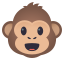

In [101]:
image_lists[791]

In [102]:
img_des = []
img_des = caption_list
np.array(img_des)

array(['sad with sweat ', 'neutral with zipper mouth ', 'yellow angry ',
       'anguished', 'anxious face with sweat', 'shocked ',
       'beaming with smiling eyes', 'quivering mouth and squinting eyes',
       'neutral with confused mouth', 'neutral with smirk and cowboy hat',
       'pleading eyes with tear', 'disappointed ',
       'stressed with forehead sweat', 'drooling mouth',
       'shocked with exploding head', 'winking kissing with a heart',
       'smiling with savouring tongue', 'screaming in fear',
       'vomiting with squinting eyes',
       'smiling blushing with hand over mouth',
       'neutral with confused mouth and bandaged head', 'mask',
       'questioning face with monocle', 'neutral with open mouth',
       'questioning face', 'rolling eyes', 'steam from nose',
       'happy with smiling eyes and tears of joy', 'ill with thermometer',
       'neutral with tongue out', 'neutral without mouth', 'fearful',
       'flushed', 'disbelief', 'neutral with unhappy sm

In [103]:
# Creating a dictionary between unique image names and unique descriptions
def load_description():

  mapping = {}
  for i in range(0,114,1):
    val = img_id[i]
    mapping[img_id[i]] = img_des[int(val)-1].strip()
  #print(img_id)
  return mapping


In [104]:
import glob
images = '/content/drive/MyDrive/Folder/uniqueimages/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.png')
img[0]

'/content/drive/MyDrive/Folder/uniqueimages/88.png'

In [105]:
#from sklearn.model_selection import train_test_split
#img_train, img_test, img_des_train, img_des_test = train_test_split(img, img_des, test_size = 0.03)

In [106]:
#print("The size of the training set is : " + str(len(img_train)))
#print("The size of the test set is : " + str(len(img_test)))

In [107]:
# Preprocessing the image names before creating the dictionary
img_id = []
for i in range(0,114,1):
    img2 = img[i].replace(".png","") #Removing the .png
    img2 = img2.replace('/content/drive/MyDrive/Folder/uniqueimages/',"") #Removing the path 
    img_id.append(img2)
  

In [108]:
descriptions = load_description()
print("Number of items: " + str(len(descriptions)))

Number of items: 114


In [109]:
descriptions # They are already clean - removed punctuation, lower case and no stop words

{'88': 'money with wings',
 '63': 'happy smile with red heart eyes',
 '77': 'worried',
 '62': 'smiling and blushing with halo',
 '76': 'flirty wink and smirking',
 '89': 'blue cap',
 '60': 'neutral with slightly unhappy smile',
 '74': 'tired',
 '48': 'liar',
 '49': 'green dollar on eyes and mouth',
 '75': 'winking with tongue out',
 '59': 'sleeping with snot',
 '61': 'neutral and smiling',
 '65': 'smirking and wearing sunglasses',
 '71': 'tired with squinting eyes',
 '64': 'smiling and blushing',
 '70': 'thinking',
 '58': 'sleeping with mouth open and zzz',
 '99': 'quivering mouth and squinting eyes',
 '8': 'quivering mouth and squinting eyes',
 '72': 'annoyed',
 '67': 'sneezing with squinting eyes',
 '66': 'smirking',
 '98': 'beaming with smiling eyes',
 '73': 'upside down smile',
 '9': 'neutral with confused mouth',
 '101': 'neutral with smirk and cowboy hat',
 '14': 'drooling mouth',
 '28': 'happy with smiling eyes and tears of joy',
 '29': 'ill with thermometer',
 '100': 'neutral w

Creating a Vocabulary

In [110]:
def to_vocab(desc):
    words = set()
    for i in range(0,114,1):
      wordsincap = caption_list[i].split(" ")
      words.update(wordsincap)
    print(words)
    return words
vocab = to_vocab(descriptions)
vocab.remove('')
print(vocab)
len(vocab)

{'', 'anguished', 'blue', 'annoyed', 'yellow', 'sack', 'confused', 'big', 'nauseous', 'shocked', 'flirty', 'orange', 'rolling', 'blushing', 'thermometer', 'mouth', 'nose', 'laughing', 'sunglasses', 'thinking', 'worried', 'braces', 'the', 'tired', 'ill', 'floor', 'open', 'sign', 'eyes', 'teeth', 'liar', 'winking', 'halo', 'disbelief', 'screaming', 'smile', 'of', 'shushing', 'disappointed', 'down', 'on', 'sneezing', 'forehead', 'quivering', 'fear', 'smiling', 'a', 'head', 'stressed', 'from', 'over', 'sleeping', 'fearful', 'tear', 'monocle', 'circle', 'wink', 'face', 'slightly', 'bunch', 'wings', 'neutral', 'drooling', 'green', 'tongue', 'dizzy', 'happy', 'sad', 'beaming', 'star', 'cap', 'with', 'zzz', 'kissing', 'books', 'upside', 'zipper', 'heart', 'tears', 'without', 'anxious', 'out', 'red', 'in', 'money', 'bandaged', 'joy', 'squinting', 'showing', 'sobbing', 'spectacles', 'pleading', 'and', 'peaceful', 'surprised', 'cowboy', 'snot', 'steam', 'wearing', 'angry', 'savouring', 'hugging',

114

In [111]:
# Renaming the image id list as train_img
train_img = img_id
train_img[14]

'71'

In [112]:
# Creating a list called train_desc that contains all the captions
train_desc = []
for i in range(0,114,1):
  val = img_id[i]
  train_desc.append(caption_list[int(val)-1])

train_desc[14]

'tired with squinting eyes'

Doing what we did with the training images with the Generated images too.

In [113]:
import glob
images = '/content/drive/MyDrive/Folder/TEST/'
# Create a list of all image names in the directory
imgs = glob.glob(images + '*.png')
imgs[45]

'/content/drive/MyDrive/Folder/TEST/83.png'

In [114]:
test_img = []
for i in range(0,114,1):
  img2 = imgs[i].replace(".png","")
  img2 = img2.replace('/content/drive/MyDrive/Folder/TEST/',"")
  test_img.append(img2)

test_img[0]

'38'

In [115]:
test_desc = []

for i in range(0,114,1):
  val = test_img[i]
  test_desc.append(caption_list[int(val)-1])
  

test_desc[0]

' happy smile with smiling eyes'

In [116]:
# Adding .png into the filenames
for i in range(0,114,1):
  train_img[i] = train_img[i] + ".png"

for i in range(0,114,1):
  test_img[i] = test_img[i] + ".png"

In [117]:
dataset_des_train = {}
dataset_des_test = {}
train_descr = []
test_descr = []
# entering the terms 'startseq' and 'endseq' before and after all the descriptions in the training and test set.
for i in range(0,114,1):
        val = train_desc[i]
        val = 'startseq ' + val + ' endseq'
        train_descr.append(val)

for i in range(0,114,1):
        val = test_desc[i]
        val = 'startseq ' + val + ' endseq'
        test_descr.append(val)

#Creating a dictionary between the test images and descriptions
def load_clean_descriptions_test(descriptions, images):
  for i in range(0,114,1):
    dataset_des_test[images[i]] = descriptions[i]
  return dataset_des_test

#Creating a dictionary between the train images and descriptions
def load_clean_descriptions_train(descriptions, images):
  for i in range(0,114,1):
    dataset_des_train[images[i]] = descriptions[i]
  return dataset_des_train


print("The length of the train_descr is : " + str(len(train_descr)))
print("The length of the test_descr is : " + str(len(test_descr)))

train_descriptions = load_clean_descriptions_train(train_descr, train_img)
test_descriptions = load_clean_descriptions_test(test_descr, test_img)

The length of the train_descr is : 114
The length of the test_descr is : 114


In [118]:
len(train_descriptions)

114

In [119]:
from keras.preprocessing.image import load_img, img_to_array
def preprocess_img(img_path):
    img = Image.open(img_path).convert('RGBA')
    x = img_to_array(img)
    # Add one more dimension
    #x = np.expand_dims(x, axis = 0)
    x = preprocess_input(x) #Normalizes between -1 and 1
    return x

In [120]:
preprocess_img("/content/drive/MyDrive/Folder/New/" + train_img[14])

array([[[-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        ...,
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.]],

       [[-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        ...,
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.]],

       [[-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        ...,
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.]],

       ...,

       [[-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        ...,
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.]],

       [[-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        ...,
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.]],

       [[-1.

In [121]:
model3 = Model(new_modelfid.input, new_modelfid.layers[-1].output)

model3.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 4)]  0           []                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 32, 32, 128)  4736        ['input_3[0][0]']                
                                                                                                  
 leaky_re_lu_6 (LeakyReLU)      (None, 32, 32, 128)  0           ['conv2d_7[0][0]']               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 16, 16, 256)  295168      ['leaky_re_lu_6[0][0]']          
                                                                                            

In [122]:
#function to encode an image into a vector using the feature detector
def encode(image,cap):
    image = preprocess_img(image)
    vec = model3.predict(image.reshape(1,64,64,4),cap.reshape(1,300))
    vec = np.reshape(vec, (vec.shape[1]))
    return vec

In [123]:
cap = vectorize_sent_list(caption_list)
cap2 = vectorize_sent_list(uniqcaptions)

In [124]:
#run the encode function on all train images
start = time.time()
encoding_train = {}
for i in range(0,114,1):
    img = "/content/drive/MyDrive/Folder/New/" + train_img[i]
    preprocessed = preprocess_img(img)
    prediction = model3.predict([preprocessed.reshape(1,64,64,4), cap[i].reshape(1,300)])
    prediction = np.reshape(prediction, (prediction.shape[1]))
    #print(prediction.shape)
    encoding_train[train_img[i]] = prediction
print("Time Taken is: " + str(time.time() - start))

Time Taken is: 5.191097736358643


In [125]:
#Encode all the test images
start = time.time()
encoding_test = {}
for i in range(0,114,1):
    img = "/content/drive/MyDrive/Folder/TEST/" + test_img[i]
    preprocessed = preprocess_img(img)
    prediction2 = model3.predict([preprocessed.reshape(1,64,64,4), cap2[i].reshape(1,300)])
    prediction2 = np.reshape(prediction2, (prediction2.shape[1]))
    encoding_test[test_img[i]] = prediction2
print("Time taken is: " + str(time.time() - start))

Time taken is: 5.154040336608887


In [126]:
train_features = encoding_train
test_features = encoding_test
print("Train image encodings: " + str(len(train_features)))
print("Test image encodings: " + str(len(test_features)))

Train image encodings: 114
Test image encodings: 114


In [127]:
train_features['6.png'].shape

(1024,)

In [128]:
#list of all training captions
all_train_captions = []
for i in range(0,114,1):
        name = train_img[i].replace(".png", "")
        name = name.replace("/content/drive/MyDrive/Folder/New/", "")
        name = int(name)
        all_train_captions.append(caption_list[name-1])

len(all_train_captions)

114

In [129]:
vocabulary = vocab
threshold = 1
word_counts = {}
for cap in all_train_captions:
    for word in cap.split(' '):
        word_counts[word] = word_counts.get(word, 0) + 1

vocab = [word for word in word_counts if word_counts[word] >= threshold]
for word in stop_words:
  if word in vocab:
    vocab.remove(word)
print("Unique words: " + str(len(word_counts)))
print("our Vocabulary: " + str(len(vocab)))

Unique words: 115
our Vocabulary: 104


In [130]:
#word mapping to integers
ixtoword = {}
wordtoix = {}

ix = 1
for word in vocab:
    wordtoix[word] = ix
    print(word)
    ixtoword[ix] = word
    ix += 1

money
wings
happy
smile
red
heart
eyes
worried
smiling
blushing
halo
flirty
wink
smirking
blue
cap
neutral
slightly
unhappy
tired

liar
green
dollar
mouth
winking
tongue
sleeping
snot
wearing
sunglasses
squinting
thinking
open
zzz
quivering
annoyed
sneezing
beaming
upside
confused
smirk
cowboy
hat
drooling
tears
joy
ill
thermometer
questioning
face
monocle
shocked
exploding
head
pleading
tear
savouring
disappointed
kissing
mask
stressed
forehead
sweat
bandaged
vomiting
hand
screaming
fear
disbelief
showing
teeth
big
steam
nose
fearful
flushed
rolling
anguished
without
floor
laughing
hugging
surprised
shushing
anxious
yellow
angry
peaceful
star
sad
bunch
books
circle
zipper
dizzy
nauseous
spectacles
braces
orange
book
sack
sign
sobbing


In [131]:
vocab_size = len(ixtoword) + 1  #1 for appended zeros
vocab_size

105

In [132]:
#find the maximum length of a description in a dataset
#max_length = max(len(des.split()) for des in all_train_captions)
max_length = 5

In [133]:
from tensorflow.keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
X1, X2, y = list(), list(), list()
for key, des_list in train_descriptions.items():
    pic = train_features[key]
    for cap in des_list:
        seq = [wordtoix[word] for word in cap.split(' ') if word in wordtoix]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
            out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
            #store
            X1.append(pic)
            X2.append(in_seq)
            y.append(out_seq)

X2 = np.array(X2)
X1 = np.array(X1)
y = np.array(y)
print(X1.shape)

(513, 1024)


In [134]:
emb_dim = 300
emb_matrix = np.zeros((vocab_size, emb_dim))
for word, i in wordtoix.items():
  for word in vocab:
    if word == '':
      pass
    else:
      emb_vec = word2em[word]
    if emb_vec is not None:
        emb_matrix[i] = emb_vec
emb_matrix.shape

(105, 300)

In [135]:
from keras.layers.normalization import batch_normalization
# define the model
emb_dim = 300
ip1 = Input(shape = (1024, ))
fe1 = Dropout(0)(ip1)
fe2 = Dense(64, activation = 'relu')(fe1)
ip2 = Input(shape = (max_length, ))
se1 = Embedding(vocab_size, emb_dim, mask_zero = True)(ip2)
se2 = Dropout(0)(se1)
se3 = LSTM(64, kernel_regularizer = 'l1_l2', recurrent_regularizer='l1_l2')(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(64, activation = 'tanh')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)
model4 = Model(inputs = [ip1, ip2], outputs = outputs)
model4.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 1024)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 5, 300)       31500       ['input_7[0][0]']                
                                                                                                  
 dropout_6 (Dropout)            (None, 1024)         0           ['input_6[0][0]']                
                                                                                            

In [136]:
model4.layers[2]

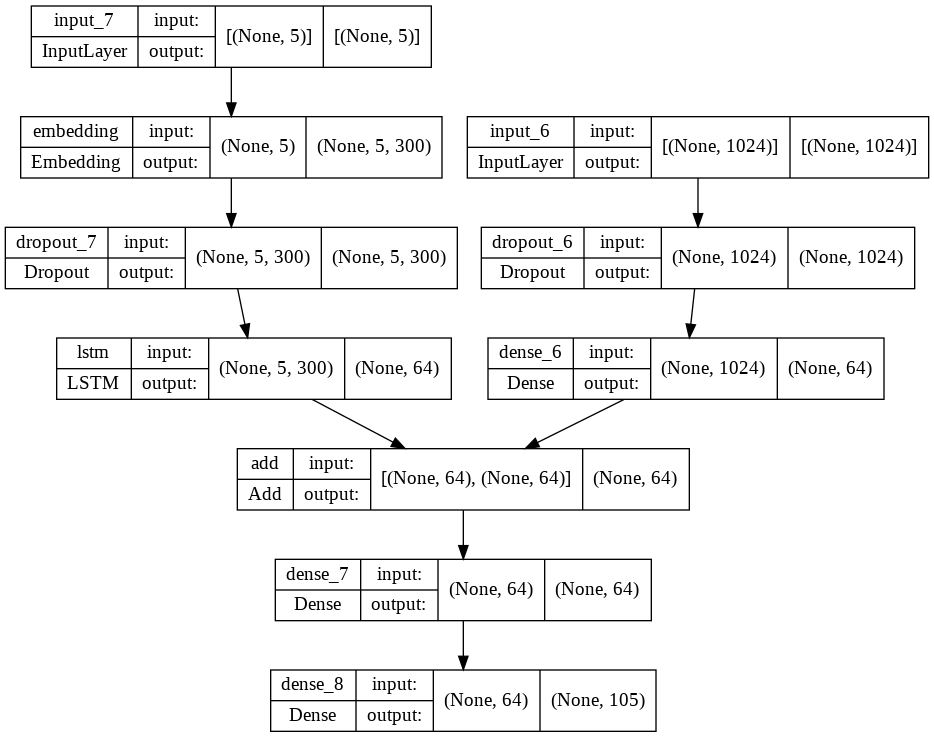

In [137]:
import keras
model4.layers[2].set_weights([emb_matrix])
model4.layers[2].trainable = False
model4.compile(loss = keras.losses.BinaryCrossentropy(), optimizer = 'Adam')
plot_model(model4, to_file = 'model.png', show_shapes = True, show_layer_names = True)

In [138]:
# Uncomment the lines below to train the model OR Run the next cell to directly load the weights
#for i in range(1):
#    model4.fit([X1, X2], y, epochs = 1, batch_size = 114)
#    model_json = model4.to_json()
#    with open("/content/drive/MyDrive/Folder/captionlossmodel.json", "w") as json_file:
#        json_file.write(model_json)
#    model4.save_weights("/content/drive/MyDrive/Folder/image-caption-weightss" + str(i) + ".h5")

In [139]:
model4.load_weights("/content/drive/MyDrive/Folder/image-caption-weightss0.h5")

In [140]:
def greedy_search(pic):
    start = 'startseq'
    for i in range(max_length):
        seq = [wordtoix[word] for word in start.split() if word in wordtoix]
        seq = pad_sequences([seq], maxlen = max_length)
        yhat = model4.predict([pic, seq])
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        start += ' ' + word
        if word == 'endseq':
            break
    final = start.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

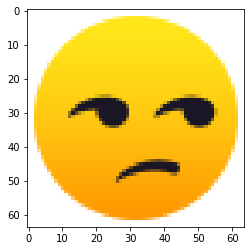

zzz confused confused confused


In [141]:
images = '/content/drive/MyDrive/Folder/uniqueimages/'
pic = '72.png'
img = encoding_train[pic].reshape(1, 1024)
x = plt.imread(images + pic)
plt.imshow(x)
plt.show()
print(greedy_search(img))

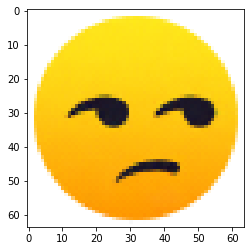

yellow confused confused confused


In [142]:
images = '/content/drive/MyDrive/Folder/TEST/'
pic = '71.png'
img = encoding_test[pic].reshape(1, 1024)
x = plt.imread(images + pic)
plt.imshow(x)
plt.show()
print(greedy_search(img))

## CAPTION LOSS USING INCEPTION V3 MODEL

In [143]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Model
from keras.layers import Flatten, Dense, LSTM, Dropout, Embedding, Activation
from keras.layers import concatenate, BatchNormalization, Input
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.utils.vis_utils import plot_model

import matplotlib.pyplot as plt
import cv2
import string
import time

In [144]:
from keras.preprocessing.image import img_to_array
import cv2
path = '/content/drive/MyDrive/Folder/New/'
def loadImages(path):
    files = os.listdir(path)
    loadedImages = []
    for i in range(1,799,1):
        name = str(i)+'.png'
        img = Image.open(path + name)
        img = img.convert('RGBA')
        #Resizing the images to 64x64 and storing in an array
        new_width  = 64
        new_height = 64
        imgresized = img.resize((new_width, new_height), Image.ANTIALIAS)
        loadedImages.append(imgresized)  
    return loadedImages
# Images in array
image_lists = loadImages(path)

In [145]:
caption_list[92]

'neutral with zipper mouth '

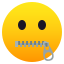

In [146]:
image_lists[92]

In [147]:
img_des = []
img_des = uniqcaptions
np.array(img_des)

array(['sad with sweat', 'neutral with zipper mouth', 'yellow angry',
       'anguished', 'anxious face with sweat', 'shocked',
       'beaming with smiling eyes', 'quivering mouth and squinting eyes',
       'neutral with confused mouth', 'neutral with smirk and cowboy hat',
       'pleading eyes with tear', 'disappointed',
       'stressed with forehead sweat', 'drooling mouth',
       'shocked with exploding head', 'winking kissing with a heart',
       'smiling with savouring tongue', 'screaming in fear',
       'vomiting with squinting eyes',
       'smiling blushing with hand over mouth',
       'neutral with confused mouth and bandaged head', 'mask',
       'questioning face with monocle', 'neutral with open mouth',
       'questioning face', 'rolling eyes', 'steam from nose',
       'happy with smiling eyes and tears of joy', 'ill with thermometer',
       'neutral with tongue out', 'neutral without mouth', 'fearful',
       'flushed', 'disbelief', 'neutral with unhappy smile',

In [148]:
# Creating a dictionary between unique image names and unique descriptions
def load_description():

  mapping = {}
  for i in range(0,114,1):
    val = img_id[i]
    mapping[img_id[i]] = img_des[int(val)-1]
  #print(img_id)
  return mapping


In [149]:
import glob
images = '/content/drive/MyDrive/Folder/uniqueimages/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.png')
img[0]

'/content/drive/MyDrive/Folder/uniqueimages/88.png'

In [150]:
# Preprocessing the image names before creating the dictionary
img_id = []
for i in range(0,114,1):
    img2 = img[i].replace(".png","") #Removing the .png
    img2 = img2.replace('/content/drive/MyDrive/Folder/uniqueimages/',"") #Removing the path 
    img_id.append(img2)
  

In [151]:
descriptions = load_description()
print("Number of items: " + str(len(descriptions)))

Number of items: 114


In [152]:
descriptions # They are already clean - removed punctuation, lower case and no stop words

{'88': 'money with wings',
 '63': 'happy smile with red heart eyes',
 '77': 'worried',
 '62': 'smiling and blushing with halo',
 '76': 'flirty wink and smirking',
 '89': 'blue cap',
 '60': 'neutral with slightly unhappy smile',
 '74': 'tired',
 '48': 'liar',
 '49': 'green dollar on eyes and mouth',
 '75': 'winking with tongue out',
 '59': 'sleeping with snot',
 '61': 'neutral and smiling',
 '65': 'smirking and wearing sunglasses',
 '71': 'tired with squinting eyes',
 '64': 'smiling and blushing',
 '70': 'thinking',
 '58': 'sleeping with mouth open and zzz',
 '99': 'zany',
 '8': 'quivering mouth and squinting eyes',
 '72': 'annoyed',
 '67': 'sneezing with squinting eyes',
 '66': 'smirking',
 '98': 'yawning',
 '73': 'upside down smile',
 '9': 'neutral with confused mouth',
 '101': 'red angry',
 '14': 'drooling mouth',
 '28': 'happy with smiling eyes and tears of joy',
 '29': 'ill with thermometer',
 '100': 'ogre',
 '114': 'monkey',
 '15': 'shocked with exploding head',
 '102': 'alien',
 

Creating a Vocabulary

In [153]:
def to_vocab(desc):
    words = set()
    for i in range(0,114,1):
      wordsincap = uniqcaptions[i].split(" ")
      words.update(wordsincap)
    print(words)
    return words
vocab = to_vocab(descriptions)
#vocab.remove('')
print(vocab)
len(vocab)

{'', 'anguished', 'monkey', 'blue', 'annoyed', 'yellow', 'sack', 'confused', 'big', 'horns', 'nauseous', 'woozy', 'shocked', 'cat', 'flirty', 'orange', 'rolling', 'blushing', 'thermometer', 'mouth', 'redbook', 'nose', 'laughing', 'sunglasses', 'thinking', 'worried', 'braces', 'the', 'tired', 'ill', 'floor', 'open', 'sign', 'eyes', 'teeth', 'liar', 'winking', 'halo', 'disbelief', 'screaming', 'smile', 'of', 'shushing', 'disappointed', 'down', 'drop', 'alien', 'on', 'sneezing', 'forehead', 'quivering', 'fear', 'clown', 'yawning', 'smiling', 'a', 'head', 'stressed', 'from', 'over', 'sleeping', 'fearful', 'tear', 'monocle', 'circle', 'wink', 'face', 'slightly', 'bunch', 'wings', 'neutral', 'drooling', 'green', 'tongue', 'dizzy', 'happy', 'cold', 'sad', 'beaming', 'star', 'cap', 'with', 'zzz', 'kissing', 'books', 'upside', 'zipper', 'blood', 'heart', 'tears', 'without', 'anxious', 'out', 'red', 'in', 'money', 'ghost', 'zany', 'bandaged', 'joy', 'squinting', 'showing', 'sobbing', 'spectacles

131

In [154]:
# Renaming the unique image id list as train_img
train_img = img_id
train_img[113]

'91'

In [155]:
# Creating a list called train_desc that contains all the Unique Captions
train_desc = []
for i in range(0,114,1):
  val = img_id[i]
  train_desc.append(uniqcaptions[int(val)-1])

train_desc[113]

'blue book'

Doing what we did with the training images with the Generated images too.

In [156]:
import glob
images = '/content/drive/MyDrive/Folder/TEST/'
# Create a list of all image names in the directory
imgs = glob.glob(images + '*.png')
imgs[45]

'/content/drive/MyDrive/Folder/TEST/83.png'

In [157]:
test_img = []
for i in range(0,114,1):
  img2 = imgs[i].replace(".png","")
  img2 = img2.replace('/content/drive/MyDrive/Folder/TEST/',"")
  test_img.append(img2)

test_img[0]

'38'

In [158]:
test_desc = []
for i in range(0,114,1):
  #val = test_img[i]
  test_desc.append(uniqcaptions[i])

test_desc[0]


'sad with sweat'

In [159]:
# Adding .png into the filenames
for i in range(0,114,1):
  train_img[i] = train_img[i] + ".png"

for i in range(0,114,1):
  test_img[i] = test_img[i] + ".png"

In [160]:
dataset_des_train = {}
dataset_des_test = {}
train_descr = []
test_descr = []
# entering the terms 'startseq' and 'endseq' before and after all the descriptions in the training and test set.
for i in range(0,114,1):
        val = train_desc[i]
        val = 'startseq ' + val + ' endseq'
        train_descr.append(val)

for i in range(0,114,1):
        val = test_desc[i]
        val = 'startseq ' + val + ' endseq'
        test_descr.append(val)

#Creating a dictionary between the test images and descriptions
def load_clean_descriptions_test(descriptions, images):
  for i in range(0,114,1):
    dataset_des_test[images[i]] = descriptions[i]
  return dataset_des_test

#Creating a dictionary between the train images and descriptions
def load_clean_descriptions_train(descriptions, images):
  for i in range(0,114,1):
    dataset_des_train[images[i]] = descriptions[i]
  return dataset_des_train


print("The length of the train_descr is : " + str(len(train_descr)))
print("The length of the test_descr is : " + str(len(test_descr)))

train_descriptions = load_clean_descriptions_train(train_descr, train_img)
test_descriptions = load_clean_descriptions_test(test_descr, test_img)

The length of the train_descr is : 114
The length of the test_descr is : 114


In [161]:
len(train_descriptions)

114

We are using InceptionV3 to find important features of the image. For that, we need to resize the images to (299,299).

In [162]:
from keras.preprocessing.image import load_img, img_to_array
def preprocess_img(img_path):
    img = load_img(img_path, target_size = (299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    x = preprocess_input(x)
    return x

In [163]:
base_model = tf.keras.applications.InceptionV3(
    include_top=True,
    weights="imagenet")
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_198 (Conv2D)            (None, 149, 149, 32  864         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_198 (Batch  (None, 149, 149, 32  96         ['conv2d_198[0][0]']             
 Normalization)                 )                                                      

In [164]:
modelx = Model(base_model.input, base_model.layers[-2].output)

In [165]:
#function to encode an image into a vector using inception v3 (getting the features)
def encode(image):
    image = preprocess_img(image)
    vec = modelx.predict(image)
    vec = np.reshape(vec, (vec.shape[1]))
    return vec

In [166]:
#run the encode function on all train images
start = time.time()
encoding_train = {}
for i in range(0,114,1):
    img = "/content/drive/MyDrive/Folder/uniqueimages/" + train_img[i]
    encoding_train[train_img[i]] = encode(img)
print("Time Taken is: " + str(time.time() - start))

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Time Taken is: 7.5221123695373535


In [167]:
#Encode all the test images
start = time.time()
encoding_test = {}
for i in range(0,114,1):
    img = "/content/drive/MyDrive/Folder/TEST/" + test_img[i]
    encoding_test[test_img[i]] = encode(img)
print("Time taken is: " + str(time.time() - start))

Time taken is: 6.251802444458008


In [168]:
train_features = encoding_train
test_features = encoding_test
print("Train image encodings: " + str(len(train_features)))
print("Test image encodings: " + str(len(test_features)))

Train image encodings: 114
Test image encodings: 114


In [169]:
train_features['6.png'].shape

(2048,)

In [170]:
#list of all training captions
all_train_captions = []
for i in range(0,114,1):
        name = train_img[i].replace(".png", "")
        name = name.replace("/content/drive/MyDrive/Folder/uniqueimages/", "")
        name = int(name)
        all_train_captions.append(caption_list[name-1])

len(all_train_captions)

114

In [171]:
vocabulary = vocab
threshold = 1
word_counts = {}
for cap in all_train_captions:
    for word in cap.split(' '):
        word_counts[word] = word_counts.get(word, 0) + 1

vocab = [word for word in word_counts if word_counts[word] >= threshold]

print("Unique words: " + str(len(word_counts)))
print("our Vocabulary: " + str(len(vocab)))

Unique words: 115
our Vocabulary: 115


In [172]:
# Mapping words to Integers
ixtoword = {}
wordtoix = {}

ix = 1
for word in vocab:
    wordtoix[word] = ix
    ixtoword[ix] = word
    ix += 1

wordtoix

{'money': 1,
 'with': 2,
 'wings': 3,
 'happy': 4,
 'smile': 5,
 'red': 6,
 'heart': 7,
 'eyes': 8,
 'worried': 9,
 'smiling': 10,
 'and': 11,
 'blushing': 12,
 'halo': 13,
 'flirty': 14,
 'wink': 15,
 'smirking': 16,
 'blue': 17,
 'cap': 18,
 'neutral': 19,
 'slightly': 20,
 'unhappy': 21,
 'tired': 22,
 '': 23,
 'liar': 24,
 'green': 25,
 'dollar': 26,
 'on': 27,
 'mouth': 28,
 'winking': 29,
 'tongue': 30,
 'out': 31,
 'sleeping': 32,
 'snot': 33,
 'wearing': 34,
 'sunglasses': 35,
 'squinting': 36,
 'thinking': 37,
 'open': 38,
 'zzz': 39,
 'quivering': 40,
 'annoyed': 41,
 'sneezing': 42,
 'beaming': 43,
 'upside': 44,
 'down': 45,
 'confused': 46,
 'smirk': 47,
 'cowboy': 48,
 'hat': 49,
 'drooling': 50,
 'tears': 51,
 'of': 52,
 'joy': 53,
 'ill': 54,
 'thermometer': 55,
 'questioning': 56,
 'face': 57,
 'monocle': 58,
 'shocked': 59,
 'exploding': 60,
 'head': 61,
 'pleading': 62,
 'tear': 63,
 'savouring': 64,
 'disappointed': 65,
 'kissing': 66,
 'a': 67,
 'mask': 68,
 'stres

In [173]:
vocab_size = len(ixtoword) + 1  #1 for appended zeros
vocab_size

116

In [174]:
#find the maximum length of a description in a dataset
#max_length = max(len(des.split()) for des in all_train_captions)
max_length = 6 

In [175]:
from tensorflow.keras.utils import to_categorical
X1, X2, y = list(), list(), list()
for key, des_list in train_descriptions.items():
    pic = train_features[key]
    for cap in des_list:
        seq = [wordtoix[word] for word in cap.split(' ') if word in wordtoix]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
            out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
            #store
            X1.append(pic)
            X2.append(in_seq)
            y.append(out_seq)

X2 = np.array(X2)
X1 = np.array(X1)
y = np.array(y)
print(X1.shape)

(465, 2048)


In [176]:
# GLOVE EMBEDDING
import urllib.request
import zipfile
def load_glove(glove_file_path, embedding_dim = 300):
    print("Loading glove file, please wait...")
    _word2em = {}
    file = open(glove_file_path, mode="rt", encoding="utf8")
    for line in file:
        words = line.strip().split()
        word = words[0]
        embeds = np.array(words[1:], dtype=np.float32)
        _word2em[word] = embeds
    file.close()
    print("Finished.")
    return _word2em

In [177]:
#word2ems = load_glove("/content/drive/MyDrive/Folder/glove.6B.200d.txt")

In [178]:
emb_dim = 300
emb_matrix = np.zeros((vocab_size, emb_dim))
for word, i in wordtoix.items():
  for word in vocab:
    if word == '':
      pass
    elif word == 'zippermouth':
      word = 'zipper'
      emb_vec = word2em[word]
    else:
      emb_vec = word2em[word]
    if emb_vec is not None:
        emb_matrix[i] = emb_vec
emb_matrix.shape

(116, 300)

In [179]:
# define the model
emb_dim = 300
ip1 = Input(shape = (2048, ))
fe1 = Dropout(0)(ip1)
fe2 = Dense(64, activation = 'relu')(fe1)
ip2 = Input(shape = (max_length, ))
se1 = Embedding(vocab_size, emb_dim, mask_zero = True)(ip2)
se2 = Dropout(0)(se1)
se3 = LSTM(64, kernel_regularizer = 'l1_l2', recurrent_regularizer='l1_l2')(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(64, activation = 'tanh')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)
model5 = Model(inputs = [ip1, ip2], outputs = outputs)
model5.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 6)]          0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 6, 300)       34800       ['input_10[0][0]']               
                                                                                                  
 dropout_8 (Dropout)            (None, 2048)         0           ['input_9[0][0]']                
                                                                                            

In [180]:
model5.layers[2]

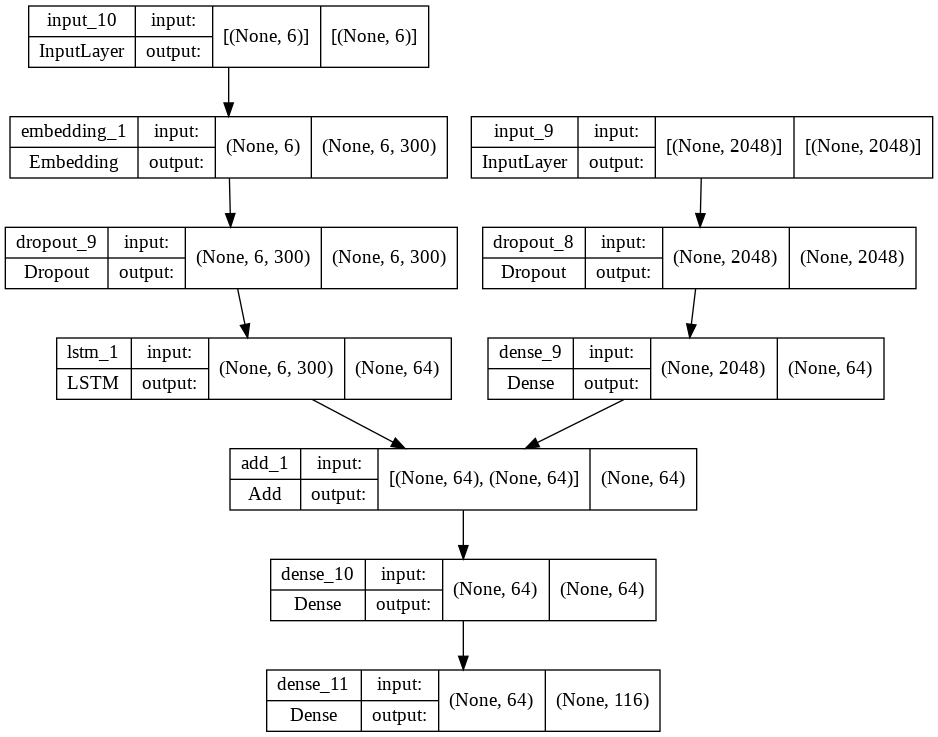

In [181]:
model5.layers[2].set_weights([emb_matrix])
model5.layers[2].trainable = False
model5.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
plot_model(model5, to_file = 'model.png', show_shapes = True, show_layer_names = True)

In [182]:
# Uncomment the lines below to train the model OR Run the next cell to load the saved weights.
#for i in range(1):
#    model5.fit([X1, X2], y, epochs = 1, batch_size = 114)
#    if(i%2 == 0):
#        model5.save_weights("/content/drive/MyDrive/Folder/image-caption-weights" + str(i+1) + ".h5")

In [183]:
model5.load_weights("/content/drive/MyDrive/Folder/image-caption-weights1.h5")

In [184]:
def greedy_search(pic):
    start = 'startseq'
    for i in range(max_length):
        seq = [wordtoix[word] for word in start.split() if word in wordtoix]
        seq = pad_sequences([seq], maxlen = max_length)
        yhat = model5.predict([pic, seq])
        yhat = np.argmax(yhat)
        #print(yhat)
        word = ixtoword[yhat]
        start += ' ' + word
        if word == 'endseq':
            break
    final = start.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

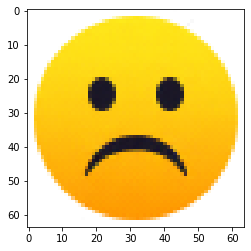

quivering quivering quivering quivering open


In [185]:
images = '/content/drive/MyDrive/Folder/TEST/'
pic = '34.png'
img = encoding_test[pic].reshape(1, 2048)
x = plt.imread(images + pic)
plt.imshow(x)
plt.show()
print(greedy_search(img))

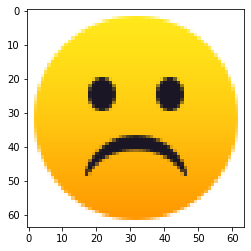

screaming quivering quivering quivering quivering


In [186]:
images = '/content/drive/MyDrive/Folder/uniqueimages/'
pic = '35.png'
img = encoding_train[pic].reshape(1, 2048)
x = plt.imread(images + pic)
plt.imshow(x)
plt.show()
print(greedy_search(img))